# Analyzing images with Azure Content Safety

## Use-case: images defect detection
### Part 3: Azure openAI gpt-4o fine tuned model for image classification

Six kinds of typical surface defects of the hot-rolled steel strip are collected, i.e., **rolled-in scale (RS), patches (Pa), crazing (Cr), pitted surface (PS), inclusion (In) and scratches (Sc)**. The database includes 1,800 grayscale images: 300(split into 240 images for training and 60 images for testing.) samples each of six different kinds of typical surface defects.

> https://www.kaggle.com/datasets/kaustubhdikshit/neu-surface-defect-database

<img src="neu.png">

### Fine tuning
**Azure OpenAI Service** allows you to customize models to your specific datasets through a process called **fine-tuning**. This step enhances the service by offering:

- Higher quality results compared to prompt engineering alone.
- The ability to train on more examples than a model's maximum request context limit.
- Token savings due to shorter prompts.
- Lower-latency requests, especially with smaller models.

Unlike few-shot learning, fine-tuning improves the model by training on many more examples than can fit in a prompt, leading to better results across various tasks. Fine-tuning adjusts the base model’s weights to enhance performance on specific tasks, reducing the need for numerous examples or instructions in your prompt. This results in less text sent and fewer tokens processed per API call, potentially lowering costs and improving request latency.

We use **LoRA (low rank approximation)** to fine-tune models, reducing their complexity without significantly impacting performance. This method approximates the original high-rank matrix with a lower rank one, fine-tuning only a smaller subset of important parameters during supervised training. This makes the model more manageable and efficient, offering faster and more affordable training for users compared to other techniques.

> Documentation: https://learn.microsoft.com/en-us/azure/ai-services/openai/how-to/fine-tuning

### About Responsible AI

GPT-4o, GPT-4o-mini, and GPT-4 are our most advanced models that can be fine-tuned to your needs. As with Azure OpenAI models generally, the advanced capabilities of fine-tuned models come with increased responsible AI challenges related to harmful content, manipulation, human-like behavior, privacy issues, and more. Learn more about risks, capabilities, and limitations in the Overview of Responsible AI practices and Transparency Note. To help mitigate the risks associated with advanced fine-tuned models, we have implemented additional evaluation steps to help detect and prevent harmful content in the training and outputs of fine-tuned models. These steps are grounded in the Microsoft Responsible AI Standard and Azure OpenAI Service content filtering.

Evaluations are conducted in dedicated, customer specific, private workspaces;
- Evaluation endpoints are in the same geography as the Azure OpenAI resource;
- Training data is not stored in connection with performing evaluations; only the final model assessment (deployable or not deployable) is persisted; and
GPT-4o, GPT-4o-mini, and GPT-4 fine-tuned model evaluation filters are set to predefined thresholds and cannot be modified by customers; they aren't tied to any custom content filtering configuration you might have created.


- https://learn.microsoft.com/en-us/legal/cognitive-services/openai/overview?context=%2Fazure%2Fai-services%2Fopenai%2Fcontext%2Fcontext
- https://learn.microsoft.com/en-us/legal/cognitive-services/openai/transparency-note?context=%2Fazure%2Fcognitive-services%2Fopenai%2Fcontext%2Fcontext&tabs=text
- https://www.microsoft.com/ai/responsible-ai
- https://learn.microsoft.com/en-us/azure/ai-services/openai/concepts/content-filter?tabs=warning%2Cpython-new


## 1 Setup

In [1]:
import base64
import json
import matplotlib.pyplot as plt
import numpy as np
import openai
import os
import pandas as pd
import requests
import sys
import time

from azure.identity import DefaultAzureCredential
from datetime import datetime
from dotenv import load_dotenv
from io import BytesIO, StringIO
from IPython.display import display, clear_output
from openai import AzureOpenAI
from PIL import Image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
from tenacity import retry, stop_after_attempt, wait_fixed
from tqdm import tqdm

%config InlineBackend.figure_format = 'retina'

In [2]:
sys.version

'3.10.14 (main, May  6 2024, 19:42:50) [GCC 11.2.0]'

In [3]:
print(f"Azure OpenAI version: {openai.__version__}")

Azure OpenAI version: 1.59.6


In [4]:
now = datetime.now()
today = now.strftime("%Y-%m-%d %H:%M:%S")
print(f"Today is {today}")

Today is 2025-01-22 15:24:30


In [5]:
project_name = "metaldefects-gpt4o"

In [6]:
load_dotenv("azure.env")

api_key = os.getenv("api_key")
azure_endpoint = os.getenv("azure_endpoint")
subscription_id = os.getenv("subscription_id")
resource_name = os.getenv("resource_name")
rg_name = os.getenv("rg_name")

In [7]:
client = AzureOpenAI(api_key=api_key,
                     api_version="2024-10-21",
                     azure_endpoint=azure_endpoint)

## 2 Helper functions

In [8]:
def encode_image(image, quality=100):
    """
    Encodes an image to a base64 string after converting it to JPEG format.

    Parameters:
    image (PIL.Image.Image): The image to be encoded.
    quality (int, optional): The quality of the JPEG encoding (default is 100).

    Returns:
    str: The base64 encoded string of the JPEG image.
    """
    if image.mode != 'RGB':
        image = image.convert('RGB')
    buffered = BytesIO()
    image.save(buffered, format="JPEG", quality=quality)

    return base64.b64encode(buffered.getvalue()).decode("utf-8")

In [9]:
def date_sorted_df(details_dict):
    """
    Converts a dictionary of details into a DataFrame, processes date columns, and sorts by creation date.

    Parameters:
    details_dict (dict): A dictionary containing the details to be converted into a DataFrame.

    Returns:
    pd.DataFrame: A DataFrame with processed date columns and sorted by 'created_at' in descending order.
    """
    df = pd.DataFrame(details_dict)

    if 'created' in df.columns:
        df.rename(columns={'created': 'created_at'}, inplace=True)

    df['created_at'] = pd.to_datetime(
        df['created_at'], unit='s').dt.strftime('%Y-%m-%d %H:%M:%S')

    if 'finished_at' in df.columns:
        df['finished_at'] = pd.to_datetime(
            df['finished_at'], unit='s',
            errors='coerce').dt.strftime('%Y-%m-%d %H:%M:%S')

    df = df.sort_values(by='created_at', ascending=False)

    return df

In [10]:
def show_ft_metrics(results_df, window_size=5):
    """
    Plots training and validation metrics from a results DataFrame with optional smoothing.

    Parameters:
    results_df (pd.DataFrame): DataFrame containing the training and validation metrics.
    window_size (int, optional): The window size for smoothing the metrics using a rolling mean
    (default is 5).

    Returns:
    None: This function displays the plots and does not return any value.
    """
    filtered_df = results_df.dropna(subset=['valid_loss'])
    filtered_df = filtered_df.loc[filtered_df['valid_loss'] != -1.0]
    results_df_smooth = results_df.rolling(window=window_size).mean()
    filtered_df_smooth = filtered_df.rolling(window=window_size).mean()

    plt.figure(figsize=(16, 10))

    plt.subplot(2, 2, 1)
    plt.plot(results_df_smooth['step'],
             results_df_smooth['train_loss'],
             color='blue')
    plt.title('Train Loss')
    plt.xlabel('Step')
    plt.ylabel('Loss')

    plt.subplot(2, 2, 2)
    plt.plot(results_df_smooth['step'],
             results_df_smooth['train_mean_token_accuracy'],
             color='green')
    plt.title('Train Mean Token Accuracy')
    plt.xlabel('Step')
    plt.ylabel('Accuracy')

    plt.subplot(2, 2, 3)
    plt.plot(filtered_df_smooth['step'],
             filtered_df_smooth['valid_loss'],
             color='red')
    plt.title('Validation Loss')
    plt.xlabel('Step')
    plt.ylabel('Loss')

    plt.subplot(2, 2, 4)
    plt.plot(filtered_df_smooth['step'],
             filtered_df_smooth['valid_mean_token_accuracy'],
             color='orange')
    plt.title('Validation Mean Token Accuracy')
    plt.xlabel('Step')
    plt.ylabel('Accuracy')

    plt.tight_layout()
    plt.show()

In [11]:
def get_ft_job_definition():
    """
    Displays the definition of the fine-tuning job.

    This function converts the fine-tuning job object to a dictionary and displays it
    using the display function for better readability.

    Returns:
        None
    """
    print("\033[1;31;34m", ft_job.to_dict())
    return ft_job.to_dict()

In [12]:
def get_ft_status(job_id):
    """
    Retrieves and prints the status of the most recent fine-tuning job.

    This function prints the current date and time, fetches the status of the most recent
    fine-tuning job from the client, prints the job status, and returns it.

    Args:
        job_id (str): The ID of the fine-tuning job to retrieve the status for.

    Returns:
        str: The status of the most recent fine-tuning job.
    """
    print("\033[1;31;34m" + datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    status = client.fine_tuning.jobs.list(limit=1).to_dict()["data"][0]["status"]
    print(f'Job status of {job_id}: {status}')

In [13]:
def get_ft_list_of_events(job_id):
    """
    Retrieves and returns a JSON-formatted list of events for a specific fine-tuning job.

    This function fetches the most recent events related to a fine-tuning job, formats the
    response as a JSON string with indentation for readability, and returns it.

    Args:
        job_id (str): The ID of the fine-tuning job to retrieve events for.

    Returns:
        str: A JSON-formatted string containing the list of events for the specified fine-tuning job.
    """
    response = client.fine_tuning.jobs.list_events(fine_tuning_job_id=job_id, limit=10)
    events = response.model_dump_json(indent=3)
    
    print("\033[1;31;34m" + datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    print(events)

In [14]:
def get_ft_job_info(job_id):
    """
    Retrieves and prints detailed information about a specific fine-tuning job.

    This function fetches the details of a fine-tuning job using the provided job ID,
    prints the job ID and status in a formatted manner, and prints the entire job
    information as a JSON-formatted string with indentation for readability.

    Args:
        job_id (str): The ID of the fine-tuning job to retrieve information for.

    Returns:
        None
    """
    response = client.fine_tuning.jobs.retrieve(job_id)
    
    print("\033[1;31;34m" + datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    print(f"Job ID: {response.id}")
    print(f"Status: {response.status}")
    print(response.model_dump_json(indent=3))

## 3 Retrieve and prepare dataset

Fine-tuning for images is possible with JSONL dataset files similar to the process of sending images as input to the chat completion API.
Images can be provided as HTTP URLs (as shown below) or data URLs containing base64-encoded images.

```json
{
  "messages": [
    { "role": "system", "content": "You are an assistant that identifies corporate logos." },
    { "role": "user", "content": "What is this logo?" },
    { "role": "user", "content": [
        {
          "type": "image_url",
          "image_url": {
            "url": "https://upload.wikimedia.org/wikipedia/fr/thumb/b/b6/Microsoft-Azure.png/100px-Microsoft-Azure.png"
          }
        }
      ]
    },
    { "role": "assistant", "content": "Microsoft Azure" }
  ]
}
```

### Image dataset requirements
- Your training file can contain a maximum of 50,000 examples that contain images (not including text examples).
- Each example can have at most 64 images.
- Each image can be at most 10 MB.

### Format
Images must be:
- JPEG
- PNG
- WEBP
Images must be in the RGB or RGBA image mode.

### Reminder
Images containing the following will be excluded from your dataset and not used for training:
- People
- Faces
- CAPTCHAs

### Reducing training cost

If you set the detail parameter for an image to low, the image is resized to 512 by 512 pixels and is only represented by 85 tokens regardless of its size. This will reduce the cost of training.

https://learn.microsoft.com/en-us/legal/cognitive-services/openai/transparency-note?context=%2Fazure%2Fai-services%2Fopenai%2Fcontext%2Fcontext&tabs=text

In [15]:
IMAGES_DIR = "defects_images"

In [16]:
class_id = ["class1", "class2", "class3", "class4", "class5", "class6"]
class_labels = ["rolled_in_scale", "pitted_surface", "patches", "inclusion", "crazing", "scratches"]

class_dict = dict(zip(class_id, class_labels))
class_dict

{'class1': 'rolled_in_scale',
 'class2': 'pitted_surface',
 'class3': 'patches',
 'class4': 'inclusion',
 'class5': 'crazing',
 'class6': 'scratches'}

In [17]:
bold_start, bold_end = '\033[1m', '\033[0m'

SYSTEM_PROMPT = f"""Analyze the provided image of metal surfaces. There are six classes of metal defects in the surface: {class_labels}. You must always return only one word value from that list. If you do not know, always choose 'unknown'."""

print(SYSTEM_PROMPT)

Analyze the provided image of metal surfaces. There are six classes of metal defects in the surface: ['rolled_in_scale', 'pitted_surface', 'patches', 'inclusion', 'crazing', 'scratches']. You must always return only one word value from that list. If you do not know, always choose 'unknown'.


In [18]:
samples = 50  # number of the first n samples images per class

In [19]:
def create_df(mydir):
    data = []
    for root, dirs, files in os.walk(mydir):
        nb = 1
        for file in files:
            if file.endswith(('png', 'jpg', 'jpeg', 'webp')):
                if nb <= samples: 
                    image_file = os.path.join(root, file)
                    img = Image.open(image_file)
                    class_label = class_dict[os.path.basename(os.path.dirname(image_file))]
                    data.append({
                        'image_file': image_file,
                        'question': SYSTEM_PROMPT,
                        'answer': class_label,
                        'image': img,
                    })
                nb += 1

    df = pd.DataFrame(data)

    return df

In [20]:
df = create_df(IMAGES_DIR)

In [21]:
df

,image_file,question,answer,image
0,defects_images/class1/class1 (1).jpg,Analyze the provided image of metal surfaces. ...,rolled_in_scale,<PIL.JpegImagePlugin.JpegImageFile image mode=...
1,defects_images/class1/class1 (10).jpg,Analyze the provided image of metal surfaces. ...,rolled_in_scale,<PIL.JpegImagePlugin.JpegImageFile image mode=...
2,defects_images/class1/class1 (100).jpg,Analyze the provided image of metal surfaces. ...,rolled_in_scale,<PIL.JpegImagePlugin.JpegImageFile image mode=...
3,defects_images/class1/class1 (101).jpg,Analyze the provided image of metal surfaces. ...,rolled_in_scale,<PIL.JpegImagePlugin.JpegImageFile image mode=...
4,defects_images/class1/class1 (102).jpg,Analyze the provided image of metal surfaces. ...,rolled_in_scale,<PIL.JpegImagePlugin.JpegImageFile image mode=...
...,...,...,...,...
295,defects_images/class6/class6 (144).jpg,Analyze the provided image of metal surfaces. ...,scratches,<PIL.JpegImagePlugin.JpegImageFile image mode=...
296,defects_images/class6/class6 (145).jpg,Analyze the provided image of metal surfaces. ...,scratches,<PIL.JpegImagePlugin.JpegImageFile image mode=...
297,defects_images/class6/class6 (146).jpg,Analyze the provided image of metal surfaces. ...,scratches,<PIL.JpegImagePlugin.JpegImageFile image mode=...
298,defects_images/class6/class6 (147).jpg,Analyze the provided image of metal surfaces. ...,scratches,<PIL.JpegImagePlugin.JpegImageFile image mode=...


In [22]:
ds_train, ds_temp = train_test_split(df, test_size=0.3, random_state=42)
ds_val, ds_test = train_test_split(ds_temp, test_size=0.5, random_state=42)

In [23]:
len(ds_train), len(ds_val), len(ds_test)

(210, 45, 45)

In [24]:
ds_val

,image_file,question,answer,image
45,defects_images/class1/class1 (140).jpg,Analyze the provided image of metal surfaces. ...,rolled_in_scale,<PIL.JpegImagePlugin.JpegImageFile image mode=...
104,defects_images/class3/class3 (102).jpg,Analyze the provided image of metal surfaces. ...,patches,<PIL.JpegImagePlugin.JpegImageFile image mode=...
9,defects_images/class1/class1 (107).jpg,Analyze the provided image of metal surfaces. ...,rolled_in_scale,<PIL.JpegImagePlugin.JpegImageFile image mode=...
211,defects_images/class5/class5 (109).jpg,Analyze the provided image of metal surfaces. ...,crazing,<PIL.JpegImagePlugin.JpegImageFile image mode=...
46,defects_images/class1/class1 (141).jpg,Analyze the provided image of metal surfaces. ...,rolled_in_scale,<PIL.JpegImagePlugin.JpegImageFile image mode=...
5,defects_images/class1/class1 (103).jpg,Analyze the provided image of metal surfaces. ...,rolled_in_scale,<PIL.JpegImagePlugin.JpegImageFile image mode=...
72,defects_images/class2/class2 (12).jpg,Analyze the provided image of metal surfaces. ...,pitted_surface,<PIL.JpegImagePlugin.JpegImageFile image mode=...
196,defects_images/class4/class4 (140).jpg,Analyze the provided image of metal surfaces. ...,inclusion,<PIL.JpegImagePlugin.JpegImageFile image mode=...
173,defects_images/class4/class4 (12).jpg,Analyze the provided image of metal surfaces. ...,inclusion,<PIL.JpegImagePlugin.JpegImageFile image mode=...
7,defects_images/class1/class1 (105).jpg,Analyze the provided image of metal surfaces. ...,rolled_in_scale,<PIL.JpegImagePlugin.JpegImageFile image mode=...


In [25]:
ds_test

,image_file,question,answer,image
93,defects_images/class2/class2 (139).jpg,Analyze the provided image of metal surfaces. ...,pitted_surface,<PIL.JpegImagePlugin.JpegImageFile image mode=...
249,defects_images/class5/class5 (143).jpg,Analyze the provided image of metal surfaces. ...,crazing,<PIL.JpegImagePlugin.JpegImageFile image mode=...
278,defects_images/class6/class6 (126).jpg,Analyze the provided image of metal surfaces. ...,scratches,<PIL.JpegImagePlugin.JpegImageFile image mode=...
108,defects_images/class3/class3 (107).jpg,Analyze the provided image of metal surfaces. ...,patches,<PIL.JpegImagePlugin.JpegImageFile image mode=...
203,defects_images/class5/class5 (101).jpg,Analyze the provided image of metal surfaces. ...,crazing,<PIL.JpegImagePlugin.JpegImageFile image mode=...
281,defects_images/class6/class6 (129).jpg,Analyze the provided image of metal surfaces. ...,scratches,<PIL.JpegImagePlugin.JpegImageFile image mode=...
73,defects_images/class2/class2 (120).jpg,Analyze the provided image of metal surfaces. ...,pitted_surface,<PIL.JpegImagePlugin.JpegImageFile image mode=...
30,defects_images/class1/class1 (126).jpg,Analyze the provided image of metal surfaces. ...,rolled_in_scale,<PIL.JpegImagePlugin.JpegImageFile image mode=...
237,defects_images/class5/class5 (132).jpg,Analyze the provided image of metal surfaces. ...,crazing,<PIL.JpegImagePlugin.JpegImageFile image mode=...
77,defects_images/class2/class2 (124).jpg,Analyze the provided image of metal surfaces. ...,pitted_surface,<PIL.JpegImagePlugin.JpegImageFile image mode=...


### Displaying some elements from the dataset

QUESTION: Analyze the provided image of metal surfaces. There are six classes of metal defects in the surface: ['rolled_in_scale', 'pitted_surface', 'patches', 'inclusion', 'crazing', 'scratches']. You must always return only one word value from that list. If you do not know, always choose 'unknown'.


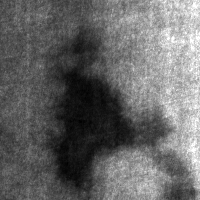

EXPECTED ANSWER: patches


In [26]:
idx = 1

print('QUESTION:', ds_train.iloc[idx]['question'])
display(ds_train.iloc[idx]['image'])
print('EXPECTED ANSWER:', ds_train.iloc[idx]['answer'])

QUESTION: Analyze the provided image of metal surfaces. There are six classes of metal defects in the surface: ['rolled_in_scale', 'pitted_surface', 'patches', 'inclusion', 'crazing', 'scratches']. You must always return only one word value from that list. If you do not know, always choose 'unknown'.


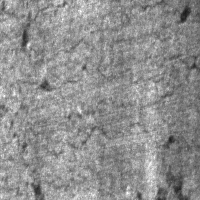

EXPECTED ANSWER: crazing


In [27]:
idx = 10

print('QUESTION:', ds_val.iloc[idx]['question'])
display(ds_train.iloc[idx]['image'])
print('EXPECTED ANSWER:', ds_train.iloc[idx]['answer'])

QUESTION: Analyze the provided image of metal surfaces. There are six classes of metal defects in the surface: ['rolled_in_scale', 'pitted_surface', 'patches', 'inclusion', 'crazing', 'scratches']. You must always return only one word value from that list. If you do not know, always choose 'unknown'.


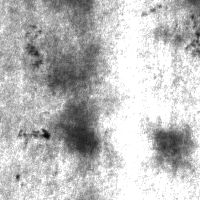

EXPECTED ANSWER: patches


In [28]:
idx = 20

print('QUESTION:', ds_test.iloc[idx]['question'])
display(ds_train.iloc[idx]['image'])
print('EXPECTED ANSWER:', ds_train.iloc[idx]['answer'])

### Generating the jsonl files

In [29]:
splits = ['train', 'val', 'test']
datasets = [ds_train, ds_val, ds_test]

for split, dataset in zip(splits, datasets):
    dataset_file = f"{project_name}-{split}.jsonl"
    print(f"Generating {dataset_file} with {dataset.shape[0]} samples.")

    json_data = []
    base64_prefix = "data:image/jpeg;base64,"

    for idx, example in tqdm(enumerate(dataset.itertuples()),
                             total=dataset.shape[0]):
        try:
            system_message = {"role": "system", "content": SYSTEM_PROMPT}

            encoded_image = encode_image(example.image, quality=80)
            user_message = {
                "role":
                "user",
                "content": [{
                    "type": "text",
                    "text": f"Question [{idx}]: {example.question}"
                }, {
                    "type": "image_url",
                    "image_url": {
                        "url": f"{base64_prefix}{encoded_image}",
                        #"detail": "auto" # The image is resized to 512x512 pixels if we choose 'low'. This will use 85 tokens whatever the initial size.
                    }
                }]
            }
            assistant_message = {
                "role": "assistant",
                "content": example.answer
            }

            json_data.append({
                "messages": [system_message, user_message, assistant_message]
            })
        except KeyError as e:
            print(f"Missing field in example {idx}: {e}")
        except Exception as e:
            print(f"Error processing example {idx}: {e}")

    with open(dataset_file, "w") as f:
        for message in json_data:
            json.dump(message, f)
            f.write("\n")

Generating metaldefects-gpt4o-train.jsonl with 210 samples.


100%|██████████| 210/210 [00:00<00:00, 1113.06it/s]


Generating metaldefects-gpt4o-val.jsonl with 45 samples.


100%|██████████| 45/45 [00:00<00:00, 1087.20it/s]


Generating metaldefects-gpt4o-test.jsonl with 45 samples.


100%|██████████| 45/45 [00:00<00:00, 1064.25it/s]


In [30]:
!ls *.jsonl -lh

-rwxrwxrwx 1 root root 493K Jan 22 15:24 metaldefects-gpt4o-test.jsonl
-rwxrwxrwx 1 root root 2.3M Jan 22 15:24 metaldefects-gpt4o-train.jsonl
-rwxrwxrwx 1 root root 489K Jan 22 15:24 metaldefects-gpt4o-val.jsonl


### Preview of jsonl file

{"messages": [{"role": "system", "content": "Analyze the provided image of metal surfaces. There are six classes of metal defects in the surface: ['rolled_in_scale', 'pitted_surface', 'patches', 'inclusion', 'crazing', 'scratches']. You must always return only one word value from that list. If you do not know, always choose 'unknown'."}, {"role": "user", "content": [{"type": "text", "text": "Question [0]: Analyze the provided image of metal surfaces. There are six classes of metal defects in the surface: ['rolled_in_scale', 'pitted_surface', 'patches', 'inclusion', 'crazing', 'scratches']. You must always return only one word value from that list. If you do not know, always choose 'unknown'."}, {"type": "image_url", "image_url": {"url": ""}}]}, {"role": "assistant", "content": "inclusion"}]}

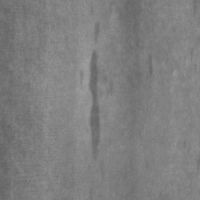

In [31]:
with open("metaldefects-gpt4o-train.jsonl", 'r') as file:
    lines = file.readlines()
    for line in lines[:1]:
        print(line.strip())

## 4 Configure and start fine-tuning job

In [32]:
# upload training file
train_file = client.files.create(file=open(f"{project_name}-train.jsonl", "rb"), purpose="fine-tune")

# upload validation file
val_file = client.files.create(file=open(f"{project_name}-val.jsonl", "rb"), purpose="fine-tune")

Here is some guidance if you want to adjust the hyperparameters of the fine-tuning process. You can keep them as `None` to use default values. 

| Hyperparameter                       | Description                                                                                                                                                                              |
|-----------------------------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| `Batch size`                            | The batch size to use for training. When set to default, batch_size is calculated as 0.2% of examples in training set and the max is 256.                                                           |
| `Learning rate multiplier` | The fine-tuning learning rate is the original learning rate used for pre-training multiplied by this multiplier. We recommend experimenting with values between 0.5 and 2. Empirically, we've found that larger learning rates often perform better with larger batch sizes. Must be between 0.0 and 5.0. |
| `Number of epochs`       | Number of training epochs. An epoch refers to one full cycle through the data set. If set to default, number of epochs will be determined dynamically based on the input data. |
| `Seed`  | The seed controls the reproducibility of the job. Passing in the same seed and job parameters should produce the same results, but may differ in rare cases. If a seed is not specified, one will be generated for you. |

### Running the fine tuning job

In [33]:
baseline_model = "gpt-4o-2024-08-06"  # Azure OpenAI baseline model (not the deployment name model from Azure AI Foundry)

In [35]:
# create fine tuning job
file_train = train_file.id
file_val = val_file.id

ft_job = client.fine_tuning.jobs.create(
    suffix=project_name,
    training_file=file_train,
    validation_file=file_val,
    model=baseline_model,  # Note: we can specify the baseline model or use an existing fine tuned model to improve
    seed=None,
    hyperparameters={
        "n_epochs": None,
        "batch_size": None,
        "learning_rate_multiplier": None,
    })

In [36]:
get_ft_job_definition()

 {'id': 'ftjob-0c5a44718cc44e519d442a8d45f6b341', 'created_at': 1737559492, 'hyperparameters': {'batch_size': -1, 'learning_rate_multiplier': 1.0, 'n_epochs': -1}, 'model': 'gpt-4o-2024-08-06', 'object': 'fine_tuning.job', 'seed': 918353715, 'status': 'pending', 'training_file': 'file-74b4a99308ab4facb56b8254755f9acf', 'validation_file': 'file-0fb1d128e599433d998be72713b733a3', 'estimated_finish': 1737560652, 'suffix': 'metaldefects-gpt4o'}


{'id': 'ftjob-0c5a44718cc44e519d442a8d45f6b341',
 'created_at': 1737559492,
 'hyperparameters': {'batch_size': -1,
  'learning_rate_multiplier': 1.0,
  'n_epochs': -1},
 'model': 'gpt-4o-2024-08-06',
 'object': 'fine_tuning.job',
 'seed': 918353715,
 'status': 'pending',
 'training_file': 'file-74b4a99308ab4facb56b8254755f9acf',
 'validation_file': 'file-0fb1d128e599433d998be72713b733a3',
 'estimated_finish': 1737560652,
 'suffix': 'metaldefects-gpt4o'}

In [37]:
job_id = ft_job.to_dict()['id']

In [38]:
get_ft_job_info(job_id)

2025-01-22 15:24:53
Job ID: ftjob-0c5a44718cc44e519d442a8d45f6b341
Status: pending
{
   "id": "ftjob-0c5a44718cc44e519d442a8d45f6b341",
   "created_at": 1737559492,
   "error": null,
   "fine_tuned_model": null,
   "finished_at": null,
   "hyperparameters": {
      "batch_size": -1,
      "learning_rate_multiplier": 1.0,
      "n_epochs": -1
   },
   "model": "gpt-4o-2024-08-06",
   "object": "fine_tuning.job",
   "organization_id": null,
   "result_files": null,
   "seed": 918353715,
   "status": "pending",
   "trained_tokens": null,
   "training_file": "file-74b4a99308ab4facb56b8254755f9acf",
   "validation_file": "file-0fb1d128e599433d998be72713b733a3",
   "estimated_finish": 1737560652,
   "integrations": null,
   "method": null,
   "suffix": "metaldefects-gpt4o"
}


### List of fine tuned jobs

In [39]:
ft_jobs = client.fine_tuning.jobs.list(limit=5).to_dict()
date_sorted_df(pd.DataFrame(ft_jobs['data']))

,id,created_at,hyperparameters,model,object,seed,status,training_file,validation_file,estimated_finish,suffix,error,finished_at,fine_tuned_model,result_files,trained_tokens
0,ftjob-0c5a44718cc44e519d442a8d45f6b341,2025-01-22 15:24:52,"{'batch_size': -1, 'learning_rate_multiplier':...",gpt-4o-2024-08-06,fine_tuning.job,918353715,pending,file-74b4a99308ab4facb56b8254755f9acf,file-0fb1d128e599433d998be72713b733a3,1737560652,metaldefects-gpt4o,NaN,NaN,NaN,NaN,NaN
1,ftjob-e369b9e1525843d78470e188dc7935b1,2025-01-22 15:08:18,"{'batch_size': -1, 'learning_rate_multiplier':...",gpt-4o-2024-08-06,fine_tuning.job,278677506,failed,file-37809ceea52f4b58921ddad9e6236413,file-a29a6ea0e1be4b608202bfbcb81c9d25,1737559659,metaldefects-gpt4o,"{'code': '400', 'message': 'User data has fail...",2025-01-22 15:12:35,NaN,NaN,NaN
2,ftjob-d44ded8dcb3646c19f8d6d28a1013179,2025-01-21 13:25:55,"{'batch_size': 1, 'learning_rate_multiplier': ...",gpt-4o-2024-08-06,fine_tuning.job,1178745847,succeeded,file-83ddb434abfa431aaa9e146d87f29268,file-8c13269572674a5588167cf15c5ac4a1,1737466919,defects-gpt4o,NaN,2025-01-22 13:28:03,gpt-4o-2024-08-06.ft-d44ded8dcb3646c19f8d6d28a...,[file-09b8b2201dc34fa787052070ae2fc482],426408.0
3,ftjob-f3e4a704ad1342b0a4ce0870f0fb80d3,2025-01-20 08:03:24,"{'batch_size': 2, 'learning_rate_multiplier': ...",gpt-4o-2024-08-06,fine_tuning.job,971325359,succeeded,file-2fdc3057ff54489fb9b0c9518b34aa53,file-518d9c12b190445e988a1b257cd33379,1737367737,vqa-gpt4o,NaN,2025-01-20 12:41:27,gpt-4o-2024-08-06.ft-f3e4a704ad1342b0a4ce0870f...,[file-b1b0c191277f444999a131bd437a6855],44224200.0
4,ftjob-c13effafe9e2421cb43f01426276c0ca,2025-01-17 16:39:12,"{'batch_size': 1, 'learning_rate_multiplier': ...",gpt-4o-2024-08-06,fine_tuning.job,1832573370,succeeded,file-f428fa1df2b843aba678363eaf7404e7,file-56085e73ebdc4876afc44d783fcd75ab,1737132876,defects_classification,NaN,2025-01-22 13:11:53,gpt-4o-2024-08-06.ft-c13effafe9e2421cb43f01426...,[file-6ced7bc7fd0642ce925622eda0e57076],271345.0


### Job status

In [40]:
get_ft_status(job_id)

2025-01-22 15:24:56
Job status of ftjob-0c5a44718cc44e519d442a8d45f6b341: pending


In [41]:
get_ft_job_info(job_id)

2025-01-22 15:24:57
Job ID: ftjob-0c5a44718cc44e519d442a8d45f6b341
Status: pending
{
   "id": "ftjob-0c5a44718cc44e519d442a8d45f6b341",
   "created_at": 1737559492,
   "error": null,
   "fine_tuned_model": null,
   "finished_at": null,
   "hyperparameters": {
      "batch_size": -1,
      "learning_rate_multiplier": 1.0,
      "n_epochs": -1
   },
   "model": "gpt-4o-2024-08-06",
   "object": "fine_tuning.job",
   "organization_id": null,
   "result_files": null,
   "seed": 918353715,
   "status": "pending",
   "trained_tokens": null,
   "training_file": "file-74b4a99308ab4facb56b8254755f9acf",
   "validation_file": "file-0fb1d128e599433d998be72713b733a3",
   "estimated_finish": 1737560652,
   "integrations": null,
   "method": null,
   "suffix": "metaldefects-gpt4o"
}


### List of events

In [42]:
get_ft_list_of_events(job_id)

2025-01-22 15:25:00
{
   "data": [
      {
         "id": "ftevent-bd47084f581c4c649049f0a387ffc70b",
         "created_at": 1737559492,
         "level": "info",
         "message": "Job enqueued. Waiting for jobs ahead to complete.",
         "object": "fine_tuning.job.event",
         "data": null,
         "type": "message"
      }
   ],
   "has_more": false,
   "object": "list"
}


### Job is running

In [44]:
get_ft_status(job_id)

2025-01-22 15:31:21
Job status of ftjob-0c5a44718cc44e519d442a8d45f6b341: running


In [45]:
get_ft_list_of_events(job_id)

2025-01-22 15:31:32
{
   "data": [
      {
         "id": "ftevent-024ce2d005fd443cb9c4e3aef6a9e165",
         "created_at": 1737559844,
         "level": "info",
         "message": "Preprocessing started.",
         "object": "fine_tuning.job.event",
         "data": null,
         "type": "message"
      },
      {
         "id": "ftevent-b14518ee1bf249629a0f2a5b2e1e9d6e",
         "created_at": 1737559835,
         "level": "error",
         "message": "Validation file: Preprocessing Summary: \nFile contains 1 examples with images that were skipped for the following reasons: contains people (1). These examples will not be used for training. Please visit our docs to learn how to resolve these issues. Using 44 valid examples from file.\n\nDetails - Samples of lines per error type:\ncontains people: Line numbers --> 44",
         "object": "fine_tuning.job.event",
         "data": null,
         "type": "message"
      },
      {
         "id": "ftevent-a9f0e3e1b08f485fa96f17e26d85fd5

In [48]:
get_ft_job_info(job_id)

2025-01-22 15:31:45
Job ID: ftjob-0c5a44718cc44e519d442a8d45f6b341
Status: running
{
   "id": "ftjob-0c5a44718cc44e519d442a8d45f6b341",
   "created_at": 1737559492,
   "error": null,
   "fine_tuned_model": null,
   "finished_at": null,
   "hyperparameters": {
      "batch_size": -1,
      "learning_rate_multiplier": 1.0,
      "n_epochs": -1
   },
   "model": "gpt-4o-2024-08-06",
   "object": "fine_tuning.job",
   "organization_id": null,
   "result_files": null,
   "seed": 918353715,
   "status": "running",
   "trained_tokens": null,
   "training_file": "file-74b4a99308ab4facb56b8254755f9acf",
   "validation_file": "file-0fb1d128e599433d998be72713b733a3",
   "estimated_finish": 1737560652,
   "integrations": null,
   "method": null,
   "suffix": "metaldefects-gpt4o"
}


### Job status in Azure AI Foundry

<img src="capture1.jpg">

In [49]:
get_ft_status(job_id)

2025-01-22 15:31:53
Job status of ftjob-0c5a44718cc44e519d442a8d45f6b341: running


In [50]:
client.fine_tuning.jobs.list(limit=1).to_dict()

{'data': [{'id': 'ftjob-0c5a44718cc44e519d442a8d45f6b341',
   'created_at': 1737559492,
   'hyperparameters': {'batch_size': -1,
    'learning_rate_multiplier': 1.0,
    'n_epochs': -1},
   'model': 'gpt-4o-2024-08-06',
   'object': 'fine_tuning.job',
   'seed': 918353715,
   'status': 'running',
   'training_file': 'file-74b4a99308ab4facb56b8254755f9acf',
   'validation_file': 'file-0fb1d128e599433d998be72713b733a3',
   'estimated_finish': 1737560652,
   'suffix': 'metaldefects-gpt4o'}],
 'has_more': True,
 'object': 'list'}

### Wait until completion

In [52]:
get_ft_status(job_id)

2025-01-22 15:32:58
Job status of ftjob-0c5a44718cc44e519d442a8d45f6b341: running


In [53]:
get_ft_list_of_events(job_id)

2025-01-22 15:33:06
{
   "data": [
      {
         "id": "ftevent-64a66ce100bf4ed1b0fe1afd4718ef3e",
         "created_at": 1737559909,
         "level": "info",
         "message": "Training started.",
         "object": "fine_tuning.job.event",
         "data": null,
         "type": "message"
      },
      {
         "id": "ftevent-1549c5f5a71d41369a2b23914247af05",
         "created_at": 1737559853,
         "level": "info",
         "message": "Job started.",
         "object": "fine_tuning.job.event",
         "data": null,
         "type": "message"
      },
      {
         "id": "ftevent-024ce2d005fd443cb9c4e3aef6a9e165",
         "created_at": 1737559844,
         "level": "info",
         "message": "Preprocessing started.",
         "object": "fine_tuning.job.event",
         "data": null,
         "type": "message"
      },
      {
         "id": "ftevent-b14518ee1bf249629a0f2a5b2e1e9d6e",
         "created_at": 1737559835,
         "level": "error",
         "message": 

In [54]:
# Get the status of our fine-tuning job.
response = client.fine_tuning.jobs.retrieve(job_id)

status = response.status

In [55]:
while status not in ["succeeded", "failed"]:
    response = client.fine_tuning.jobs.retrieve(job_id)
    status = response.status
    print("\033[1;31;34m")
    print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
    response = client.fine_tuning.jobs.retrieve(job_id)
    print("\n", response.model_dump_json(indent=2))
    status = response.status
    print(f'\nStatus: {status}')
    clear_output(wait=True)  # Refresh current cell
    time.sleep(600)  # Wait 10 min

print(f"Fine-tuning job {job_id} finished with status: {status}")

Fine-tuning job ftjob-0c5a44718cc44e519d442a8d45f6b341 finished with status: succeeded


In [57]:
client.fine_tuning.jobs.list(limit=1).to_dict()

{'data': [{'id': 'ftjob-0c5a44718cc44e519d442a8d45f6b341',
   'created_at': 1737559492,
   'fine_tuned_model': 'gpt-4o-2024-08-06.ft-0c5a44718cc44e519d442a8d45f6b341-metaldefects-gpt4o',
   'finished_at': 1737566400,
   'hyperparameters': {'batch_size': 1,
    'learning_rate_multiplier': 1.0,
    'n_epochs': 3},
   'model': 'gpt-4o-2024-08-06',
   'object': 'fine_tuning.job',
   'result_files': ['file-9df1bcd2a40141d49e30e426e7f1a408'],
   'seed': 918353715,
   'status': 'succeeded',
   'trained_tokens': 1734588,
   'training_file': 'file-74b4a99308ab4facb56b8254755f9acf',
   'validation_file': 'file-0fb1d128e599433d998be72713b733a3',
   'estimated_finish': 1737560652,
   'suffix': 'metaldefects-gpt4o'}],
 'has_more': True,
 'object': 'list'}

In [59]:
get_ft_job_info(job_id)

2025-01-22 17:36:14
Job ID: ftjob-0c5a44718cc44e519d442a8d45f6b341
Status: succeeded
{
   "id": "ftjob-0c5a44718cc44e519d442a8d45f6b341",
   "created_at": 1737559492,
   "error": null,
   "fine_tuned_model": "gpt-4o-2024-08-06.ft-0c5a44718cc44e519d442a8d45f6b341-metaldefects-gpt4o",
   "finished_at": 1737566400,
   "hyperparameters": {
      "batch_size": 1,
      "learning_rate_multiplier": 1.0,
      "n_epochs": 3
   },
   "model": "gpt-4o-2024-08-06",
   "object": "fine_tuning.job",
   "organization_id": null,
   "result_files": [
      "file-9df1bcd2a40141d49e30e426e7f1a408"
   ],
   "seed": 918353715,
   "status": "succeeded",
   "trained_tokens": 1734588,
   "training_file": "file-74b4a99308ab4facb56b8254755f9acf",
   "validation_file": "file-0fb1d128e599433d998be72713b733a3",
   "estimated_finish": 1737560652,
   "integrations": null,
   "method": null,
   "suffix": "metaldefects-gpt4o"
}


In [60]:
get_ft_list_of_events(job_id)

2025-01-22 17:36:17
{
   "data": [
      {
         "id": "ftevent-0f1da30dc78e418ea5e8d61c942e80bb",
         "created_at": 1737566400,
         "level": "info",
         "message": "Training tokens billed: 270000",
         "object": "fine_tuning.job.event",
         "data": null,
         "type": "message"
      },
      {
         "id": "ftevent-2a639c86b4ca4776a9d86ff0ed4e5391",
         "created_at": 1737566400,
         "level": "info",
         "message": "Model Evaluation Passed.",
         "object": "fine_tuning.job.event",
         "data": null,
         "type": "message"
      },
      {
         "id": "ftevent-f704482c816a4da1b0d190f28f4ca0db",
         "created_at": 1737566400,
         "level": "info",
         "message": "Completed results file: file-9df1bcd2a40141d49e30e426e7f1a408",
         "object": "fine_tuning.job.event",
         "data": null,
         "type": "message"
      },
      {
         "id": "ftevent-31c666ce41b94711ae66d0ea4e8f5432",
         "created_

<img src="capture2.jpg">

### Fine tuning job metrics

In [67]:
get_ft_status(job_id)

2025-01-22 17:38:05
Job status of ftjob-0c5a44718cc44e519d442a8d45f6b341: succeeded


In [68]:
# Retrieve the state of a fine-tune job
ft_job = client.fine_tuning.jobs.retrieve(job_id)
ft_job.to_dict()

{'id': 'ftjob-0c5a44718cc44e519d442a8d45f6b341',
 'created_at': 1737559492,
 'fine_tuned_model': 'gpt-4o-2024-08-06.ft-0c5a44718cc44e519d442a8d45f6b341-metaldefects-gpt4o',
 'finished_at': 1737566400,
 'hyperparameters': {'batch_size': 1,
  'learning_rate_multiplier': 1.0,
  'n_epochs': 3},
 'model': 'gpt-4o-2024-08-06',
 'object': 'fine_tuning.job',
 'result_files': ['file-9df1bcd2a40141d49e30e426e7f1a408'],
 'seed': 918353715,
 'status': 'succeeded',
 'trained_tokens': 1734588,
 'training_file': 'file-74b4a99308ab4facb56b8254755f9acf',
 'validation_file': 'file-0fb1d128e599433d998be72713b733a3',
 'estimated_finish': 1737560652,
 'suffix': 'metaldefects-gpt4o'}

In [69]:
start = ft_job.to_dict()['created_at']
end = ft_job.to_dict()['finished_at']
start_dt = datetime.fromtimestamp(start)
end_dt = datetime.fromtimestamp(end)
elapsed = end_dt - start_dt

print(f"{start_dt} Model training starts")
print(f"{end_dt} End of model training")
print(f"Training duration: {elapsed}")

trained_tokens = ft_job.to_dict()['trained_tokens']
print(f"Trained tokens: {trained_tokens:,}")

2025-01-22 15:24:52 Model training starts
2025-01-22 17:20:00 End of model training
Training duration: 1:55:08
Trained tokens: 1,734,588


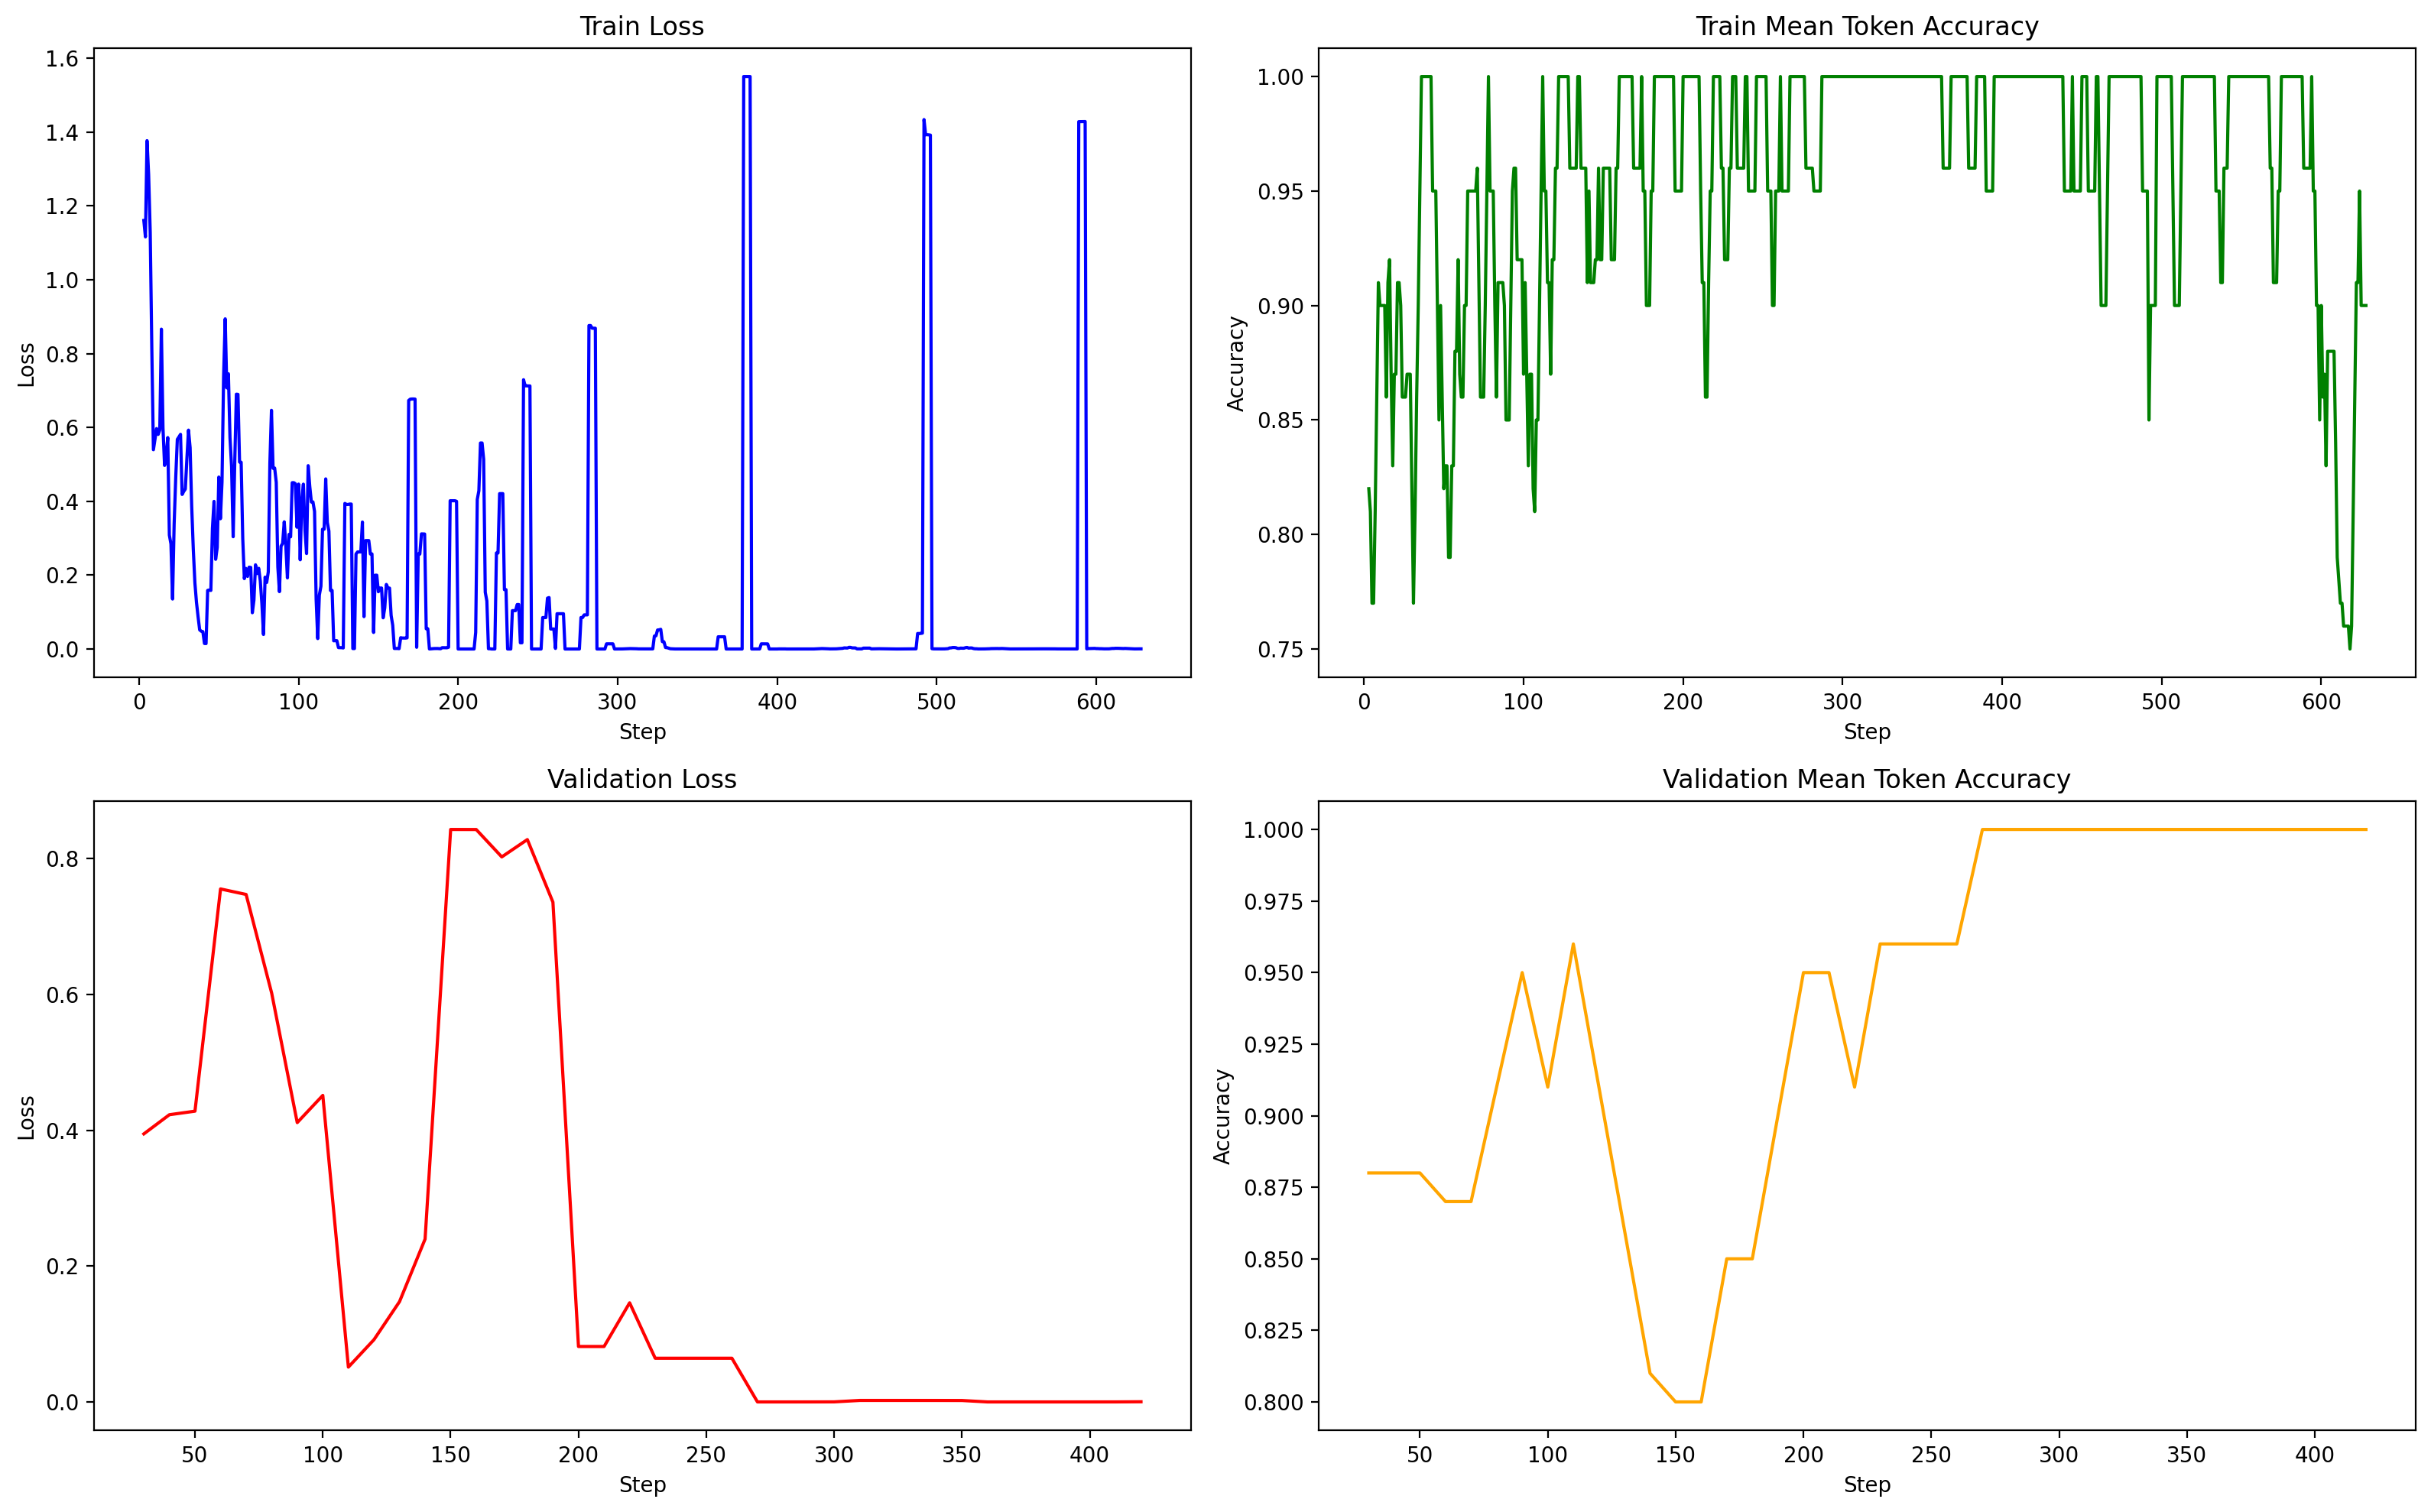

In [70]:
# Retrieve fine-tuning metrics from result file
result_file_id = ft_job.to_dict()['result_files'][0]
results_content = client.files.content(result_file_id).content.decode()
data_io = StringIO(results_content)
results_df = pd.read_csv(data_io)
show_ft_metrics(results_df)

Take a look at this table for an interpretation of above diagrams:  

| Metric                       | Description                                                                                                                                                                              |
|-----------------------------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| `step`                            | The number of the training step. A training step represents a single pass, forward and backward, on a batch of training data.                                                           |
| `train_loss`, `validation_loss` | The loss for the training / validation batch |
| `train_mean_token_accuracy`       | The percentage of tokens in the training batch correctly predicted by the model. For example, if the batch size is set to 3 and your data contains completions [[1, 2], [0, 5], [4, 2]], this value is set to 0.83 (5 of 6) if the model predicted [[1, 1], [0, 5], [4, 2]]. |
| `validation_mean_token_accuracy`  | The percentage of tokens in the validation batch correctly predicted by the model. For example, if the batch size is set to 3 and your data contains completions [[1, 2], [0, 5], [4, 2]], this value is set to 0.83 (5 of 6) if the model predicted [[1, 1], [0, 5], [4, 2]]. |

## 5 Deploy fine-tuned model
> __Note__  
> Only one deployment is permitted for a customized model. An error occurs if you select an already-deployed customized model.  

The code below shows how to deploy the model using the Control Plane API. Take a look at the [Azure OpenAI fine-tuning documentation](https://learn.microsoft.com/en-us/azure/ai-services/openai/how-to/fine-tuning?tabs=turbo&pivots=programming-language-python#deploy-fine-tuned-model) for more details.

In [71]:
my_models = client.models.list().to_dict()
models_df = date_sorted_df(my_models['data'])
cols = ['status', 'capabilities', 'lifecycle_status', 'id', 'created_at', 'model']

print(f'Models of Azure OpenAI resource {bold_start}{resource_name}{bold_end}:')
display(models_df[cols].head())

Models of Azure OpenAI resource azureopenai-sweden-sr:


,status,capabilities,lifecycle_status,id,created_at,model
85,succeeded,"{'fine_tune': False, 'inference': True, 'compl...",generally-available,gpt-4o-2024-08-06.ft-0c5a44718cc44e519d442a8d4...,2025-01-22 15:24:52,gpt-4o-2024-08-06
84,succeeded,"{'fine_tune': False, 'inference': True, 'compl...",generally-available,gpt-4o-2024-08-06.ft-0c5a44718cc44e519d442a8d4...,2025-01-22 15:24:52,gpt-4o-2024-08-06
83,succeeded,"{'fine_tune': False, 'inference': True, 'compl...",generally-available,gpt-4o-2024-08-06.ft-0c5a44718cc44e519d442a8d4...,2025-01-22 15:24:52,gpt-4o-2024-08-06
80,succeeded,"{'fine_tune': False, 'inference': True, 'compl...",generally-available,gpt-4o-2024-08-06.ft-d44ded8dcb3646c19f8d6d28a...,2025-01-21 13:25:55,gpt-4o-2024-08-06
81,succeeded,"{'fine_tune': False, 'inference': True, 'compl...",generally-available,gpt-4o-2024-08-06.ft-d44ded8dcb3646c19f8d6d28a...,2025-01-21 13:25:55,gpt-4o-2024-08-06


In [72]:
models_df

,id,object,status,capabilities,lifecycle_status,deprecation,created_at,model,fine_tune
85,gpt-4o-2024-08-06.ft-0c5a44718cc44e519d442a8d4...,model,succeeded,"{'fine_tune': False, 'inference': True, 'compl...",generally-available,{'inference': 1747699200},2025-01-22 15:24:52,gpt-4o-2024-08-06,ftjob-0c5a44718cc44e519d442a8d45f6b341
84,gpt-4o-2024-08-06.ft-0c5a44718cc44e519d442a8d4...,model,succeeded,"{'fine_tune': False, 'inference': True, 'compl...",generally-available,{'inference': 1747699200},2025-01-22 15:24:52,gpt-4o-2024-08-06,ftjob-0c5a44718cc44e519d442a8d45f6b341
83,gpt-4o-2024-08-06.ft-0c5a44718cc44e519d442a8d4...,model,succeeded,"{'fine_tune': False, 'inference': True, 'compl...",generally-available,{'inference': 1747699200},2025-01-22 15:24:52,gpt-4o-2024-08-06,ftjob-0c5a44718cc44e519d442a8d45f6b341
80,gpt-4o-2024-08-06.ft-d44ded8dcb3646c19f8d6d28a...,model,succeeded,"{'fine_tune': False, 'inference': True, 'compl...",generally-available,{'inference': 1747699200},2025-01-21 13:25:55,gpt-4o-2024-08-06,ftjob-d44ded8dcb3646c19f8d6d28a1013179
81,gpt-4o-2024-08-06.ft-d44ded8dcb3646c19f8d6d28a...,model,succeeded,"{'fine_tune': False, 'inference': True, 'compl...",generally-available,{'inference': 1747699200},2025-01-21 13:25:55,gpt-4o-2024-08-06,ftjob-d44ded8dcb3646c19f8d6d28a1013179
...,...,...,...,...,...,...,...,...,...
43,text-search-babbage-query-001,model,succeeded,"{'fine_tune': False, 'inference': True, 'compl...",generally-available,{'inference': 1718323200},2022-05-20 00:00:00,NaN,NaN
50,davinci,model,succeeded,"{'fine_tune': False, 'inference': False, 'comp...",generally-available,"{'fine_tune': 1718323200, 'inference': 1718323...",2022-03-01 00:00:00,NaN,NaN
31,ada,model,succeeded,"{'fine_tune': False, 'inference': False, 'comp...",generally-available,"{'fine_tune': 1718323200, 'inference': 1718323...",2022-03-01 00:00:00,NaN,NaN
46,curie,model,succeeded,"{'fine_tune': False, 'inference': False, 'comp...",generally-available,"{'fine_tune': 1718323200, 'inference': 1718323...",2022-03-01 00:00:00,NaN,NaN


In [73]:
fine_tuned_model = models_df['id'].values[0].split(':')[0]
fine_tuned_model

'gpt-4o-2024-08-06.ft-0c5a44718cc44e519d442a8d45f6b341-metaldefects-gpt4o'

In [74]:
aoai_deployment_name = project_name  # AOAI deployment name. Use as model parameter for inferencing
credential = DefaultAzureCredential()
token = credential.get_token("https://management.azure.com/.default").token

deploy_params = {'api-version': "2023-05-01"}

deploy_headers = {
    'Authorization': 'Bearer {}'.format(token),
    'Content-Type': 'application/json'
}

deploy_data = {
    "sku": {
        "name": "standard",
        "capacity": 1
    },
    "properties": {
        "model": {
            "format": "OpenAI",
            "name": fine_tuned_model,
            "version": "1"
        }
    }
}

deploy_data = json.dumps(deploy_data)

request_url = f"https://management.azure.com/subscriptions/{subscription_id}/resourceGroups/{rg_name}/providers/Microsoft.CognitiveServices/accounts/{resource_name}/deployments/{aoai_deployment_name}"

In [81]:
data_json = json.loads(deploy_data)
print(json.dumps(data_json, indent=4))

{
    "sku": {
        "name": "standard",
        "capacity": 1
    },
    "properties": {
        "model": {
            "format": "OpenAI",
            "name": "gpt-4o-2024-08-06.ft-0c5a44718cc44e519d442a8d45f6b341-metaldefects-gpt4o",
            "version": "1"
        }
    }
}


In [78]:
print("Creating a new deployment ...\n")

req = requests.put(request_url,
                   params=deploy_params,
                   headers=deploy_headers,
                   data=deploy_data)
print("Done")

Creating a new deployment ...

Done


### Deployed model is in the deployment section of Azure AI Foundry

<img src="capture3.jpg" width=800>

### FT model deployment information

In [82]:
print(req)

<Response [201]>


In [83]:
print(req.reason)

Created


In [84]:
response_json = req.json()
print(json.dumps(response_json, indent=3))

{
   "id": "/subscriptions/b8acd8e6-3841-4717-8469-82e36dad9ae5/resourceGroups/azureopenai-suede-rg/providers/Microsoft.CognitiveServices/accounts/azureopenai-sweden-sr/deployments/metaldefects-gpt4o",
   "type": "Microsoft.CognitiveServices/accounts/deployments",
   "name": "metaldefects-gpt4o",
   "sku": {
      "name": "standard",
      "capacity": 1
   },
   "properties": {
      "model": {
         "format": "OpenAI",
         "name": "gpt-4o-2024-08-06.ft-0c5a44718cc44e519d442a8d45f6b341-metaldefects-gpt4o",
         "version": "1"
      },
      "versionUpgradeOption": "NoAutoUpgrade",
      "capabilities": {
         "area": "EUR",
         "chatCompletion": "true",
         "jsonSchemaResponse": "true",
         "maxContextToken": "128000",
         "maxOutputToken": "16384"
      },
      "provisioningState": "Creating"
   },
   "systemData": {
      "createdBy": "Serge.Retkowsky@microsoft.com",
      "createdByType": "User",
      "createdAt": "2025-01-22T17:38:59.6106963Z",

> Wait until the model is deployed

### Model deployment is SUCCEEDED

<img src="capture4.jpg">

## 6 Evaluate default versus fine-tuned model

In [85]:
ds_test

,image_file,question,answer,image
93,defects_images/class2/class2 (139).jpg,Analyze the provided image of metal surfaces. ...,pitted_surface,<PIL.JpegImagePlugin.JpegImageFile image mode=...
249,defects_images/class5/class5 (143).jpg,Analyze the provided image of metal surfaces. ...,crazing,<PIL.JpegImagePlugin.JpegImageFile image mode=...
278,defects_images/class6/class6 (126).jpg,Analyze the provided image of metal surfaces. ...,scratches,<PIL.JpegImagePlugin.JpegImageFile image mode=...
108,defects_images/class3/class3 (107).jpg,Analyze the provided image of metal surfaces. ...,patches,<PIL.JpegImagePlugin.JpegImageFile image mode=...
203,defects_images/class5/class5 (101).jpg,Analyze the provided image of metal surfaces. ...,crazing,<PIL.JpegImagePlugin.JpegImageFile image mode=...
281,defects_images/class6/class6 (129).jpg,Analyze the provided image of metal surfaces. ...,scratches,<PIL.JpegImagePlugin.JpegImageFile image mode=...
73,defects_images/class2/class2 (120).jpg,Analyze the provided image of metal surfaces. ...,pitted_surface,<PIL.JpegImagePlugin.JpegImageFile image mode=...
30,defects_images/class1/class1 (126).jpg,Analyze the provided image of metal surfaces. ...,rolled_in_scale,<PIL.JpegImagePlugin.JpegImageFile image mode=...
237,defects_images/class5/class5 (132).jpg,Analyze the provided image of metal surfaces. ...,crazing,<PIL.JpegImagePlugin.JpegImageFile image mode=...
77,defects_images/class2/class2 (124).jpg,Analyze the provided image of metal surfaces. ...,pitted_surface,<PIL.JpegImagePlugin.JpegImageFile image mode=...


### Test Inference

"Analyze the provided image of metal surfaces. There are six classes of metal defects in the surface: ['rolled_in_scale', 'pitted_surface', 'patches', 'inclusion', 'crazing', 'scratches']. You must always return only one word value from that list. If you do not know, always choose 'unknown'."

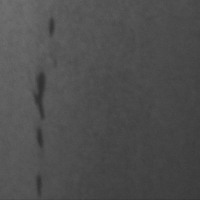

'Expected answer: inclusion'

In [86]:
idx = 10

question = ds_test.iloc[idx]['question']
img = ds_test.iloc[idx]['image']
answer = ds_test.iloc[idx]['answer']

display(question)
display(img)
display(f"Expected answer: {answer}")

In [87]:
@retry(stop=stop_after_attempt(3), wait=wait_fixed(10))
def calling_classification_model(image, question, deployment='gpt-4o'):
    """
    Queries an image-based question to a specified model deployment and returns the response.

    Parameters:
    image (PIL.Image.Image): The image to be encoded and queried.
    question (str): The question related to the image.
    deployment (str, optional): The model deployment to use for querying (default is 'gpt-4o').

    Returns:
    str: The response content from the model.
    """
    encoded_image_url = f"data:image/jpeg;base64,{encode_image(image, quality=50)}"

    response = client.chat.completions.create(
        model=deployment,
        messages=[{
            "role": "system",
            "content": SYSTEM_PROMPT
        }, {
            "role":
            "user",
            "content": [{
                "type": "text",
                "text": question
            }, {
                "type": "image_url",
                "image_url": {
                    "url": encoded_image_url
                }
            }]
        }],
        temperature=0,
    )

    return response.choices[0].message.content

In [88]:
print("Answer is:\n")
display(answer)

Answer is:



'inclusion'

In [89]:
print(f"Image classification using the baseline model {baseline_model}: {calling_classification_model(img, question, baseline_model)}")

Image classification using the baseline model gpt-4o-2024-08-06: scratches


> Incorrect answer

In [90]:
print(f"Image classification using the fine-tuned model {project_name}: {calling_classification_model(img, question, project_name)}")

Image classification using the fine-tuned model metaldefects-gpt4o: inclusion


> Correct answer

### Use the base model

In [91]:
# Process test dataset with baseline model
print("Baseline model:", baseline_model)
start = time.time()

ds_test['gpt-4o-base-pred'] = ds_test.apply(
    lambda row: calling_classification_model(row['image'], row['question'], baseline_model),
    axis=1)

minutes, seconds = divmod((time.time() - start), 60)
print(f"Elapsed time = {minutes:.0f} minutes and {seconds:.2f} seconds")

Baseline model: gpt-4o-2024-08-06
Elapsed time = 1 minutes and 8.69 seconds


In [92]:
ds_test

,image_file,question,answer,image,gpt-4o-base-pred
93,defects_images/class2/class2 (139).jpg,Analyze the provided image of metal surfaces. ...,pitted_surface,<PIL.JpegImagePlugin.JpegImageFile image mode=...,pitted_surface
249,defects_images/class5/class5 (143).jpg,Analyze the provided image of metal surfaces. ...,crazing,<PIL.JpegImagePlugin.JpegImageFile image mode=...,crazing
278,defects_images/class6/class6 (126).jpg,Analyze the provided image of metal surfaces. ...,scratches,<PIL.JpegImagePlugin.JpegImageFile image mode=...,scratches
108,defects_images/class3/class3 (107).jpg,Analyze the provided image of metal surfaces. ...,patches,<PIL.JpegImagePlugin.JpegImageFile image mode=...,patches
203,defects_images/class5/class5 (101).jpg,Analyze the provided image of metal surfaces. ...,crazing,<PIL.JpegImagePlugin.JpegImageFile image mode=...,unknown
281,defects_images/class6/class6 (129).jpg,Analyze the provided image of metal surfaces. ...,scratches,<PIL.JpegImagePlugin.JpegImageFile image mode=...,scratches
73,defects_images/class2/class2 (120).jpg,Analyze the provided image of metal surfaces. ...,pitted_surface,<PIL.JpegImagePlugin.JpegImageFile image mode=...,pitted_surface
30,defects_images/class1/class1 (126).jpg,Analyze the provided image of metal surfaces. ...,rolled_in_scale,<PIL.JpegImagePlugin.JpegImageFile image mode=...,pitted_surface
237,defects_images/class5/class5 (132).jpg,Analyze the provided image of metal surfaces. ...,crazing,<PIL.JpegImagePlugin.JpegImageFile image mode=...,scratches
77,defects_images/class2/class2 (124).jpg,Analyze the provided image of metal surfaces. ...,pitted_surface,<PIL.JpegImagePlugin.JpegImageFile image mode=...,patches


### Use the fine tuned model

In [93]:
# Process test dataset with fine-tuned model
print("Fine-tuned model:", project_name)
start = time.time()

ds_test['gpt-4o-ft-pred'] = ds_test.apply(
    lambda row: calling_classification_model(row['image'], row['question'], project_name),
    axis=1)

minutes, seconds = divmod((time.time() - start), 60)
print(f"Elapsed time = {minutes:.0f} minutes and {seconds:.2f} seconds")

Fine-tuned model: metaldefects-gpt4o
Elapsed time = 0 minutes and 31.35 seconds


In [94]:
ds_test

,image_file,question,answer,image,gpt-4o-base-pred,gpt-4o-ft-pred
93,defects_images/class2/class2 (139).jpg,Analyze the provided image of metal surfaces. ...,pitted_surface,<PIL.JpegImagePlugin.JpegImageFile image mode=...,pitted_surface,pitted_surface
249,defects_images/class5/class5 (143).jpg,Analyze the provided image of metal surfaces. ...,crazing,<PIL.JpegImagePlugin.JpegImageFile image mode=...,crazing,crazing
278,defects_images/class6/class6 (126).jpg,Analyze the provided image of metal surfaces. ...,scratches,<PIL.JpegImagePlugin.JpegImageFile image mode=...,scratches,scratches
108,defects_images/class3/class3 (107).jpg,Analyze the provided image of metal surfaces. ...,patches,<PIL.JpegImagePlugin.JpegImageFile image mode=...,patches,patches
203,defects_images/class5/class5 (101).jpg,Analyze the provided image of metal surfaces. ...,crazing,<PIL.JpegImagePlugin.JpegImageFile image mode=...,unknown,crazing
281,defects_images/class6/class6 (129).jpg,Analyze the provided image of metal surfaces. ...,scratches,<PIL.JpegImagePlugin.JpegImageFile image mode=...,scratches,scratches
73,defects_images/class2/class2 (120).jpg,Analyze the provided image of metal surfaces. ...,pitted_surface,<PIL.JpegImagePlugin.JpegImageFile image mode=...,pitted_surface,pitted_surface
30,defects_images/class1/class1 (126).jpg,Analyze the provided image of metal surfaces. ...,rolled_in_scale,<PIL.JpegImagePlugin.JpegImageFile image mode=...,pitted_surface,pitted_surface
237,defects_images/class5/class5 (132).jpg,Analyze the provided image of metal surfaces. ...,crazing,<PIL.JpegImagePlugin.JpegImageFile image mode=...,scratches,crazing
77,defects_images/class2/class2 (124).jpg,Analyze the provided image of metal surfaces. ...,pitted_surface,<PIL.JpegImagePlugin.JpegImageFile image mode=...,patches,pitted_surface


### Exports

In [95]:
# Export to CSV and excel files
output_file = f"defects_ft_evaluation_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}"
output_csv_file = f"{output_file}.csv"
output_excel_file = f"{output_file}.xlsx"

In [96]:
# Export to CSV
ds_test.to_csv(output_csv_file, index=False)
!ls $output_csv_file -lh

-rwxrwxrwx 1 root root 20K Jan 22 17:54 defects_ft_evaluation_2025-01-22_17-54-51.csv


In [97]:
# Export to Excel
ds_test.to_excel(output_excel_file)
!ls $output_excel_file -lh

-rwxrwxrwx 1 root root 7.2K Jan 22 17:54 defects_ft_evaluation_2025-01-22_17-54-51.xlsx


## Base line confusion matrix

In [111]:
y_true = ds_test[['answer']].to_numpy()
y_pred = ds_test[['gpt-4o-base-pred']].to_numpy()
labels = np.unique(np.concatenate([y_true, y_pred]))

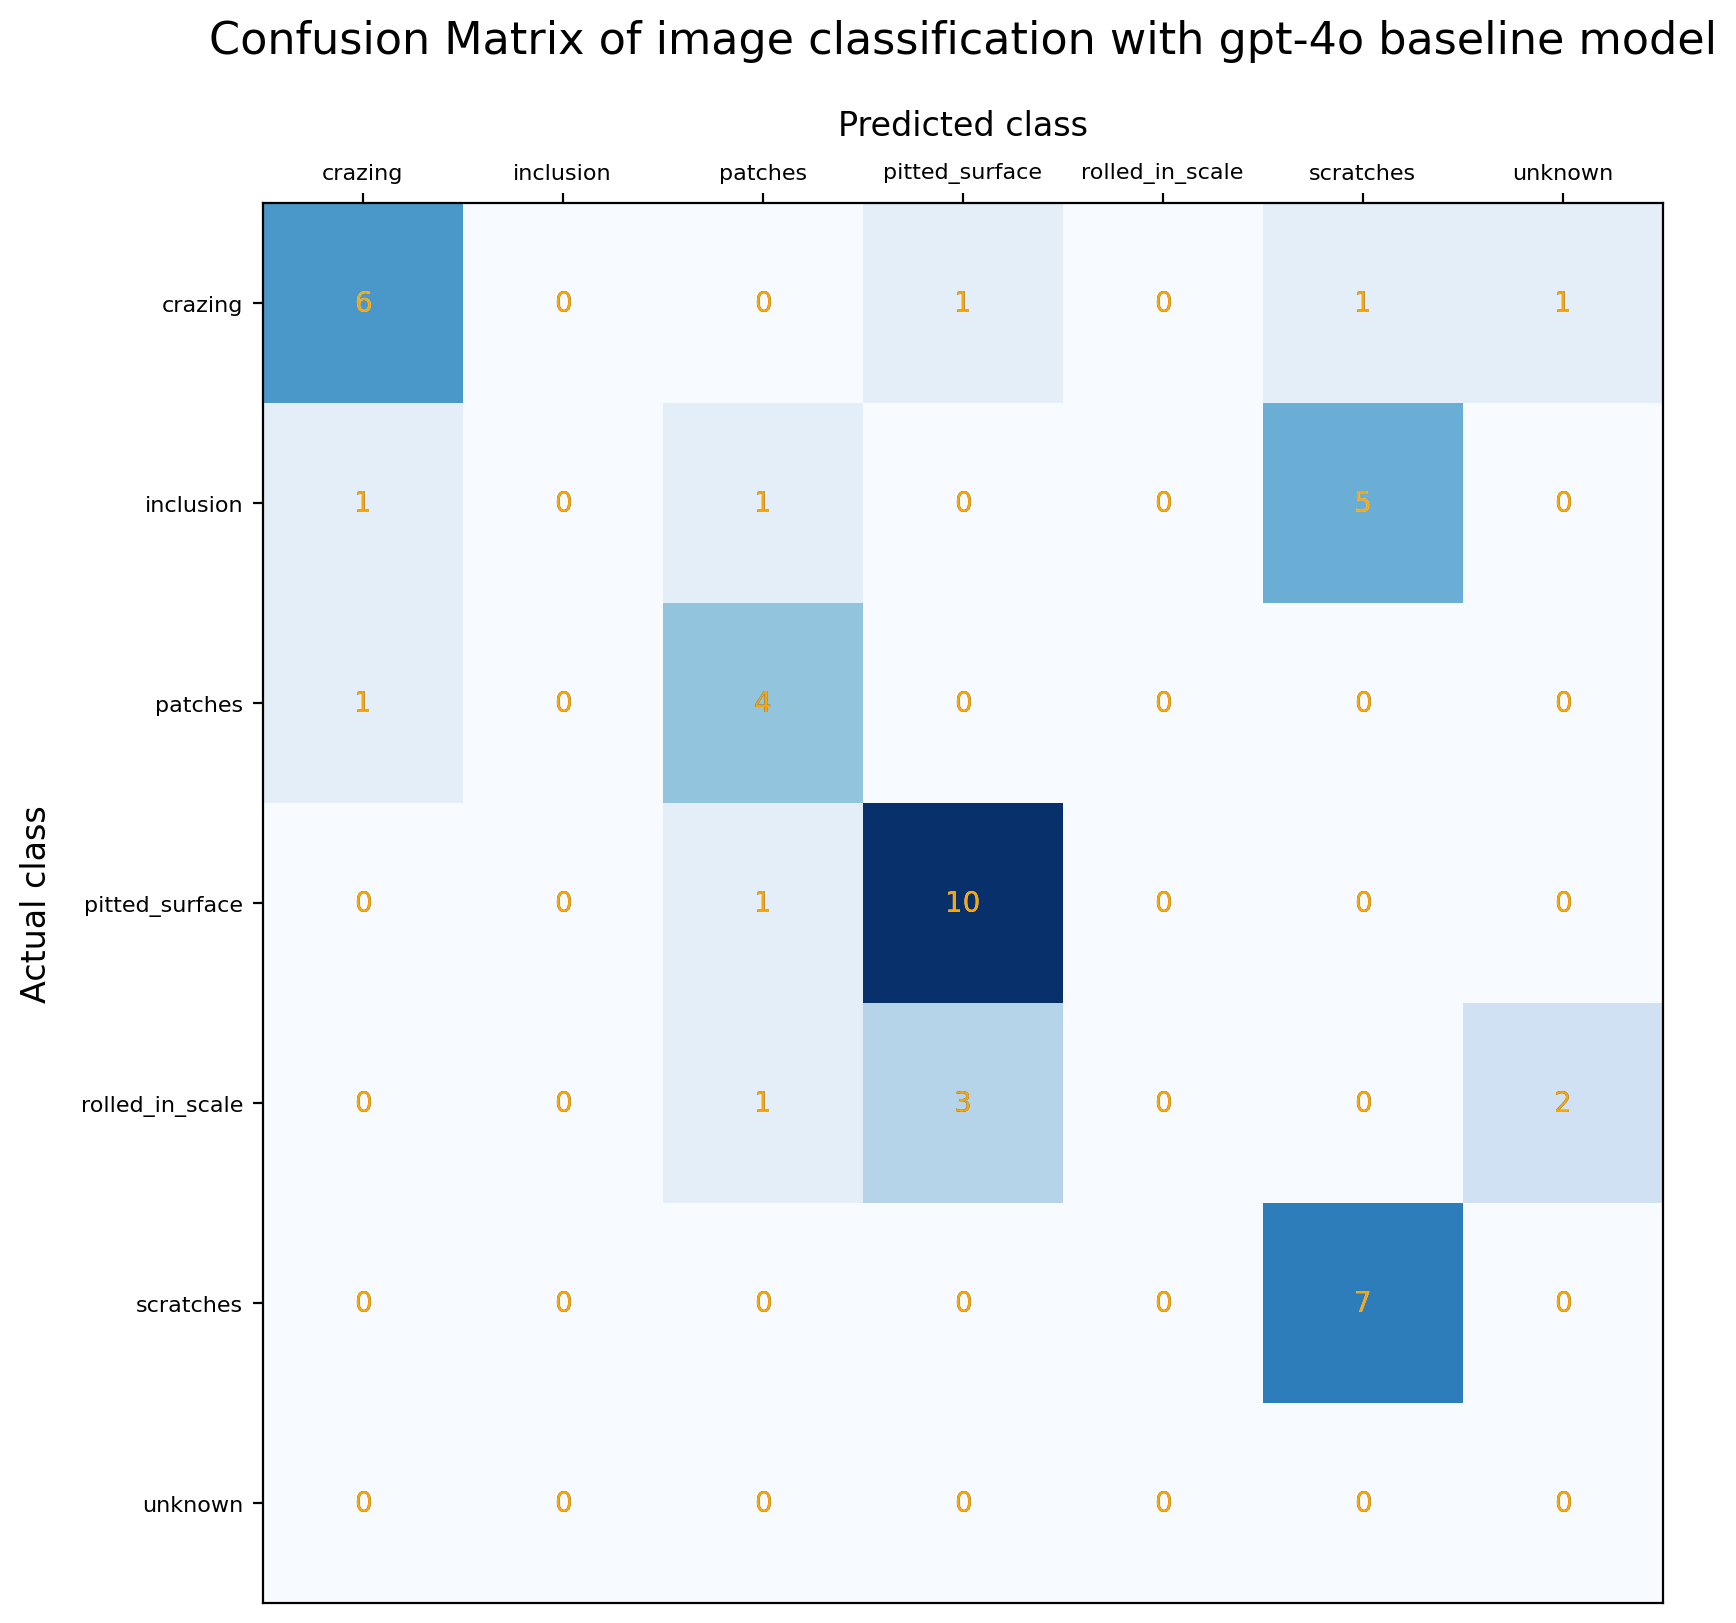

In [112]:
cm = confusion_matrix(y_true, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues, ax=ax, colorbar=False)

for (i, j), value in np.ndenumerate(cm):
    ax.text(j,
            i,
            f"{value}",
            ha="center",
            va="center",
            fontsize=10,
            color="orange")

ax.set_title(
    "Confusion Matrix of image classification with gpt-4o baseline model",
    fontsize=16,
    pad=20)

ax.set_xlabel("Predicted class", fontsize=12, labelpad=10)
ax.set_ylabel("Actual class", fontsize=12, labelpad=10)
ax.xaxis.set_label_position("top")
ax.xaxis.tick_top()
ax.tick_params(axis='both', which='major', labelsize=8)
ax.set_xticks(np.arange(len(class_labels)), minor=True)
ax.set_yticks(np.arange(len(class_labels)), minor=True)
ax.grid(which="minor", color="black", linestyle="--", linewidth=1)
plt.subplots_adjust(bottom=0.1, top=0.9, left=0.15, right=0.85)
plt.savefig("baseline_confmatrix.png")
plt.show()

In [113]:
print(classification_report(y_true, y_pred, target_names=labels, zero_division=0))

                 precision    recall  f1-score   support

        crazing       0.75      0.67      0.71         9
      inclusion       0.00      0.00      0.00         7
        patches       0.57      0.80      0.67         5
 pitted_surface       0.71      0.91      0.80        11
rolled_in_scale       0.00      0.00      0.00         6
      scratches       0.54      1.00      0.70         7
        unknown       0.00      0.00      0.00         0

       accuracy                           0.60        45
      macro avg       0.37      0.48      0.41        45
   weighted avg       0.47      0.60      0.52        45



In [114]:
accuracy_base = np.diag(cm).sum() / cm.sum()
print("\033[1;31;34m")
print(f"GPT-4o base line model accuracy = {accuracy_base * 100:.2f}%")


GPT-4o base line model accuracy = 60.00%


## Fine tuning confusion matrix

In [115]:
y_true = ds_test[['answer']].to_numpy()
y_pred = ds_test[['gpt-4o-ft-pred']].to_numpy()
labels = np.unique(np.concatenate([y_true, y_pred]))

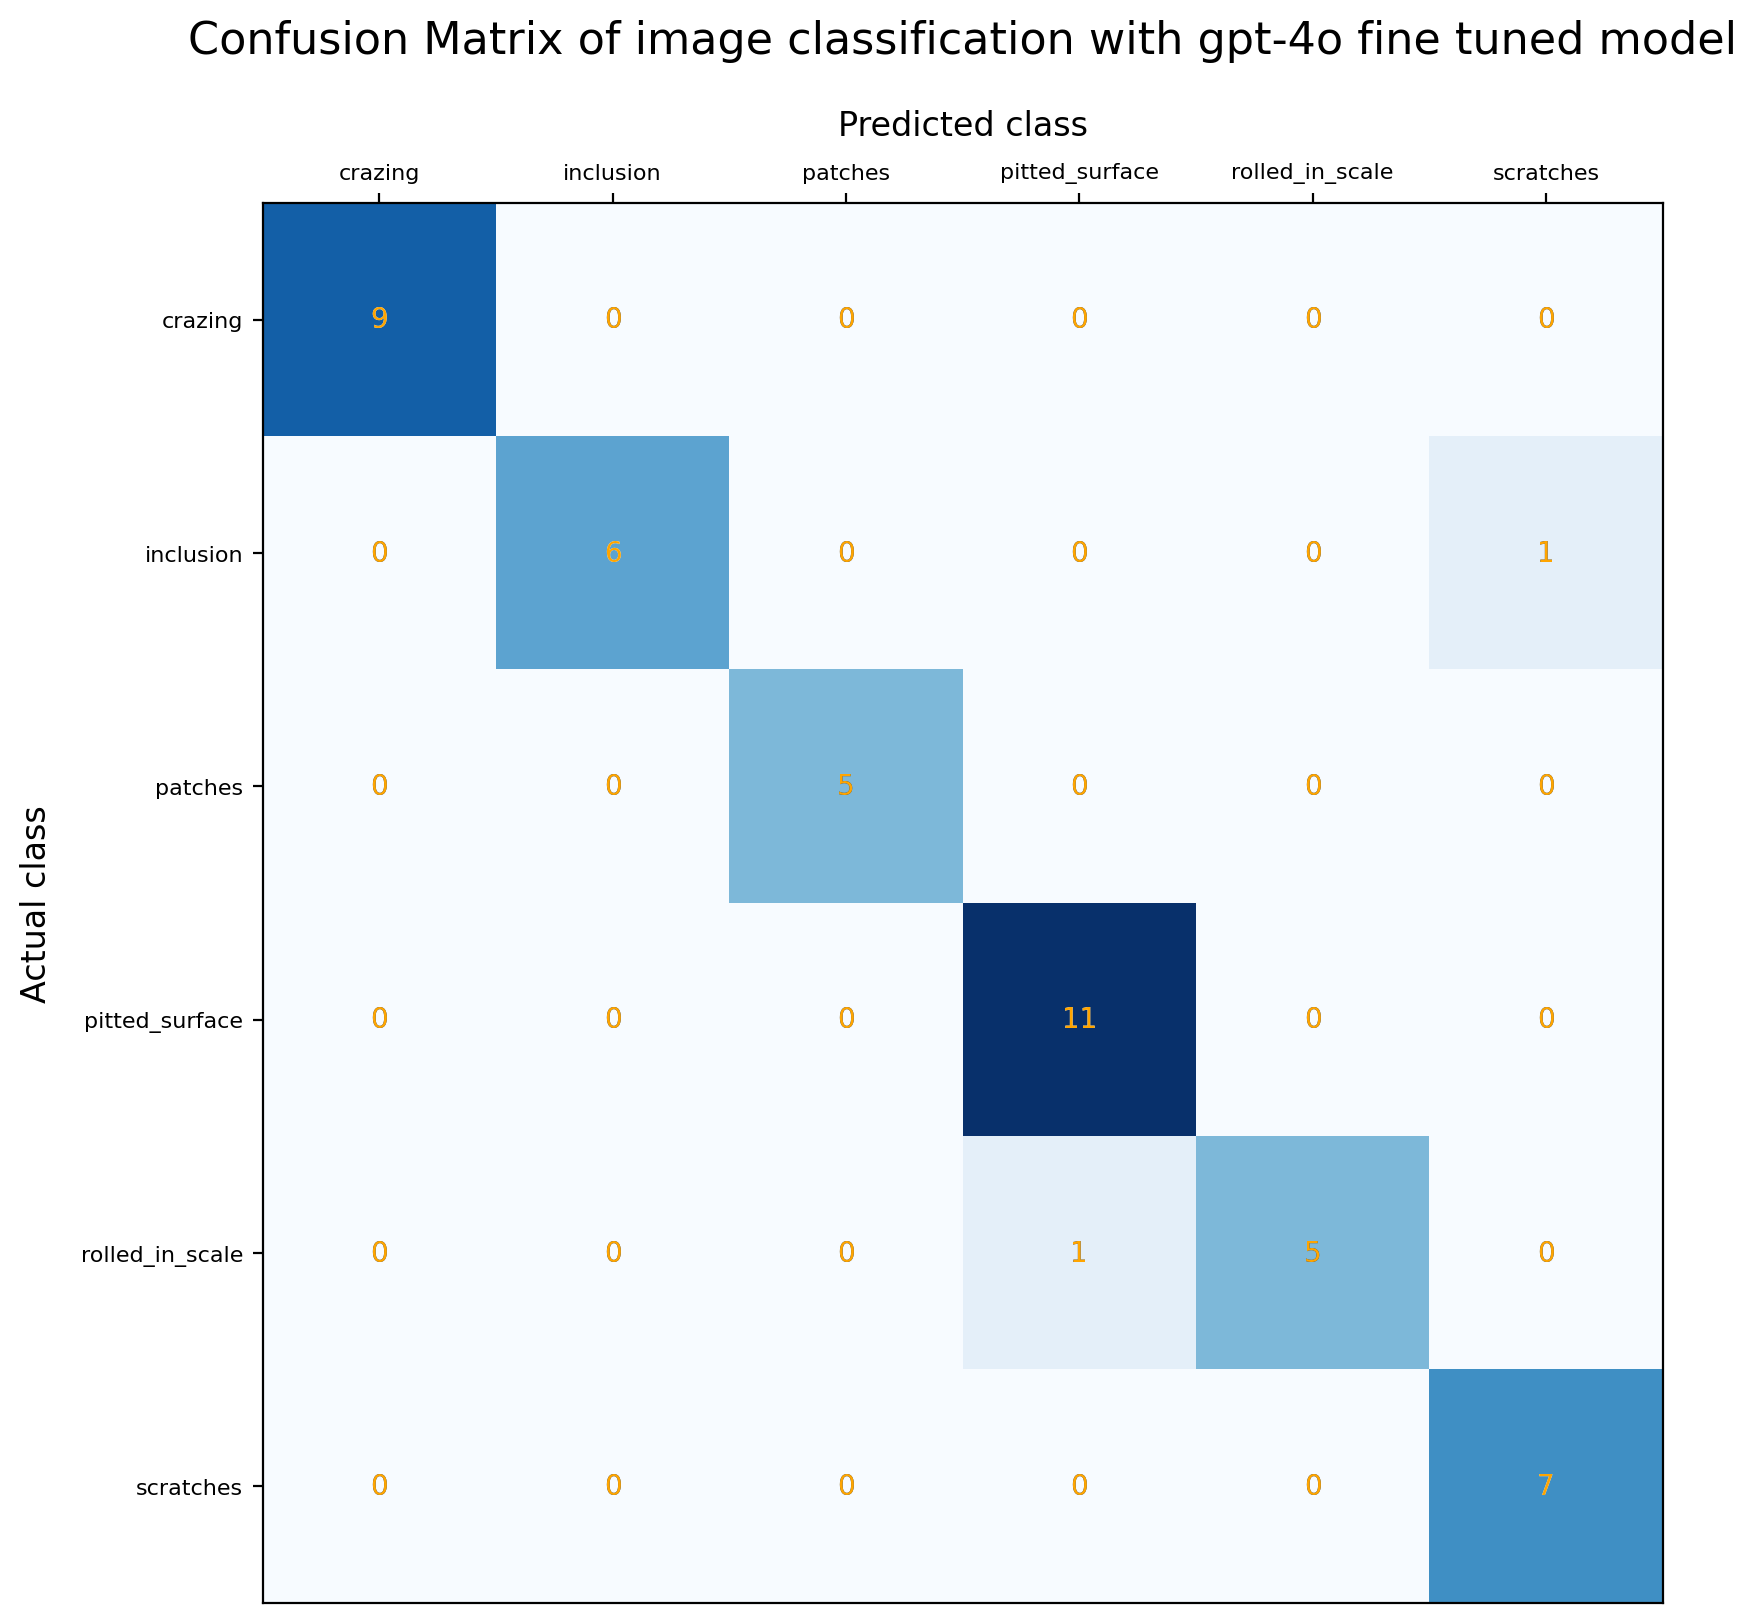

In [116]:
cm = confusion_matrix(y_true, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues, ax=ax, colorbar=False)

for (i, j), value in np.ndenumerate(cm):
    ax.text(j,
            i,
            f"{value}",
            ha="center",
            va="center",
            fontsize=10,
            color="orange")

ax.set_title(
    "Confusion Matrix of image classification with gpt-4o fine tuned model",
    fontsize=16,
    pad=20)

ax.set_xlabel("Predicted class", fontsize=12, labelpad=10)
ax.set_ylabel("Actual class", fontsize=12, labelpad=10)
ax.xaxis.set_label_position("top")
ax.xaxis.tick_top()
ax.tick_params(axis='both', which='major', labelsize=8)
ax.set_xticks(np.arange(len(class_labels)), minor=True)
ax.set_yticks(np.arange(len(class_labels)), minor=True)
ax.grid(which="minor", color="gray", linestyle="--", linewidth=1)
plt.subplots_adjust(bottom=0.1, top=0.9, left=0.15, right=0.85)
plt.savefig("ft_confmatrix.png")
plt.show()

In [117]:
print(classification_report(y_true, y_pred, target_names=labels, zero_division=0))

                 precision    recall  f1-score   support

        crazing       1.00      1.00      1.00         9
      inclusion       1.00      0.86      0.92         7
        patches       1.00      1.00      1.00         5
 pitted_surface       0.92      1.00      0.96        11
rolled_in_scale       1.00      0.83      0.91         6
      scratches       0.88      1.00      0.93         7

       accuracy                           0.96        45
      macro avg       0.97      0.95      0.95        45
   weighted avg       0.96      0.96      0.95        45



In [118]:
accuracy_ft = np.diag(cm).sum() / cm.sum()
print("\033[1;31;34m")
print(f"GPT-4o Fine tuned model accuracy = {accuracy_ft * 100:.2f}%")


GPT-4o Fine tuned model accuracy = 95.56%


## Conclusion

In [138]:
print("\033[1;31;34m")
print(f"GPT-4o base line model accuracy  = {accuracy_base * 100:.2f}%")
print(f"GPT-4o Fine tuned model accuracy = {accuracy_ft * 100:.2f}%")
difference = accuracy_ft - accuracy_base
print("\033[1;31;32m")
print(f">> Improvement in accuracy with the fine tuned model = +{difference * 100:.2f}%")


GPT-4o base line model accuracy  = 60.00%
GPT-4o Fine tuned model accuracy = 95.56%

>> Improvement in accuracy with the fine tuned model = +35.56%


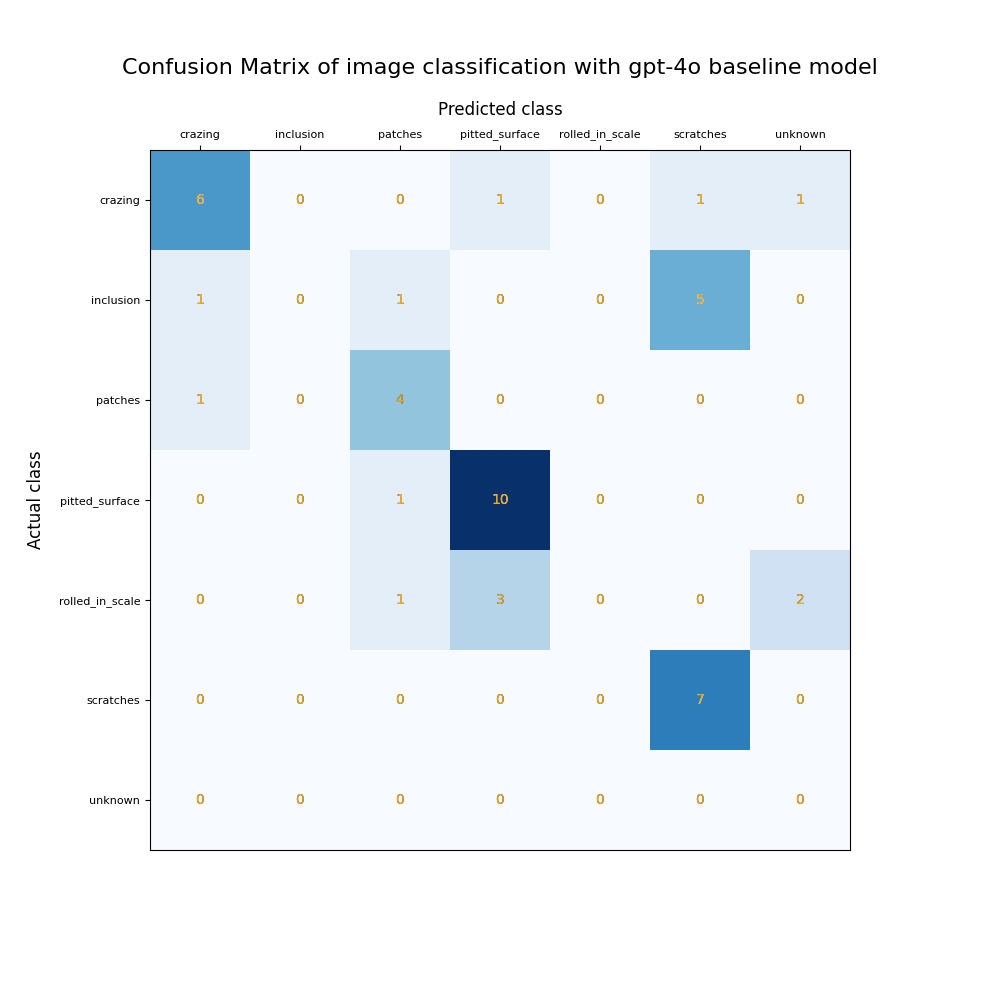

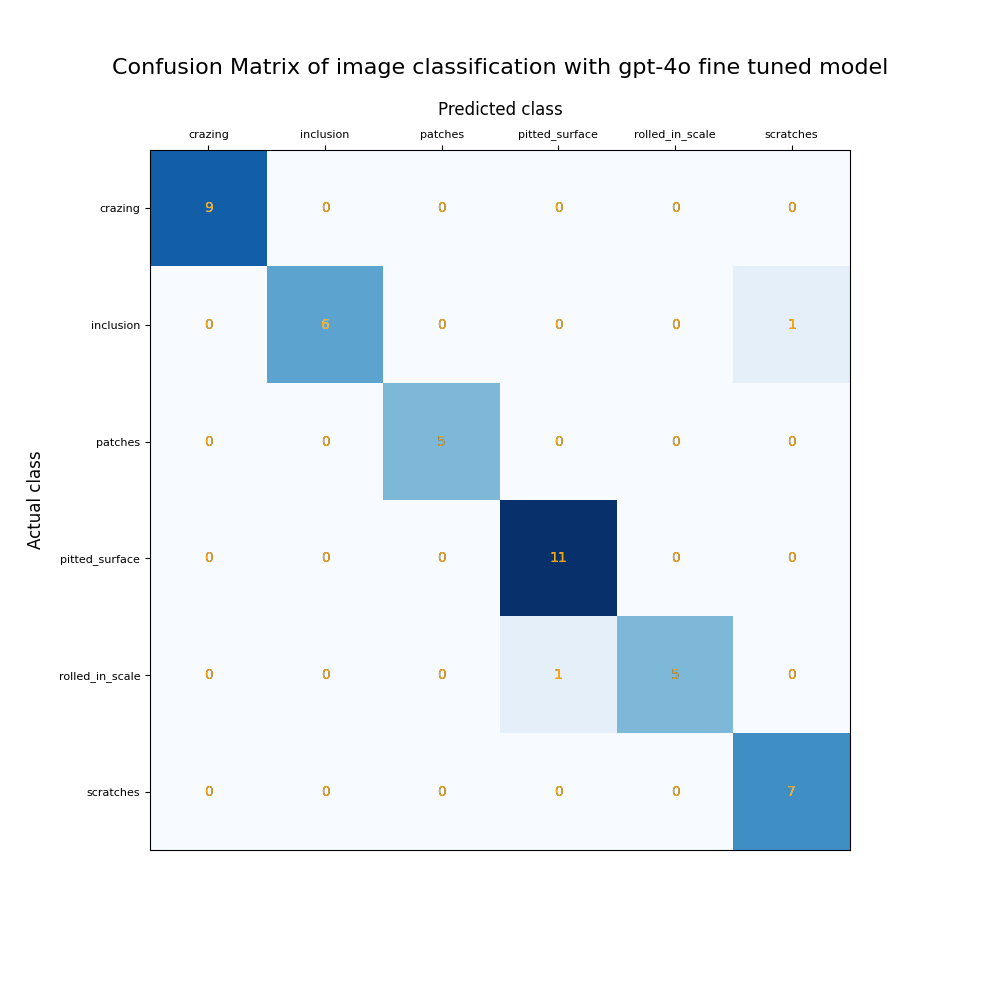

In [127]:
cm1 = 'baseline_confmatrix.png'
cm2 = 'ft_confmatrix.png'

img1 = Image.open(cm1)
img2 = Image.open(cm2)
display(img1, img2)

In [108]:
ds_test[["image_file", "answer", "gpt-4o-base-pred", "gpt-4o-ft-pred"]]

,image_file,answer,gpt-4o-base-pred,gpt-4o-ft-pred
93,defects_images/class2/class2 (139).jpg,pitted_surface,pitted_surface,pitted_surface
249,defects_images/class5/class5 (143).jpg,crazing,crazing,crazing
278,defects_images/class6/class6 (126).jpg,scratches,scratches,scratches
108,defects_images/class3/class3 (107).jpg,patches,patches,patches
203,defects_images/class5/class5 (101).jpg,crazing,unknown,crazing
281,defects_images/class6/class6 (129).jpg,scratches,scratches,scratches
73,defects_images/class2/class2 (120).jpg,pitted_surface,pitted_surface,pitted_surface
30,defects_images/class1/class1 (126).jpg,rolled_in_scale,pitted_surface,pitted_surface
237,defects_images/class5/class5 (132).jpg,crazing,scratches,crazing
77,defects_images/class2/class2 (124).jpg,pitted_surface,patches,pitted_surface


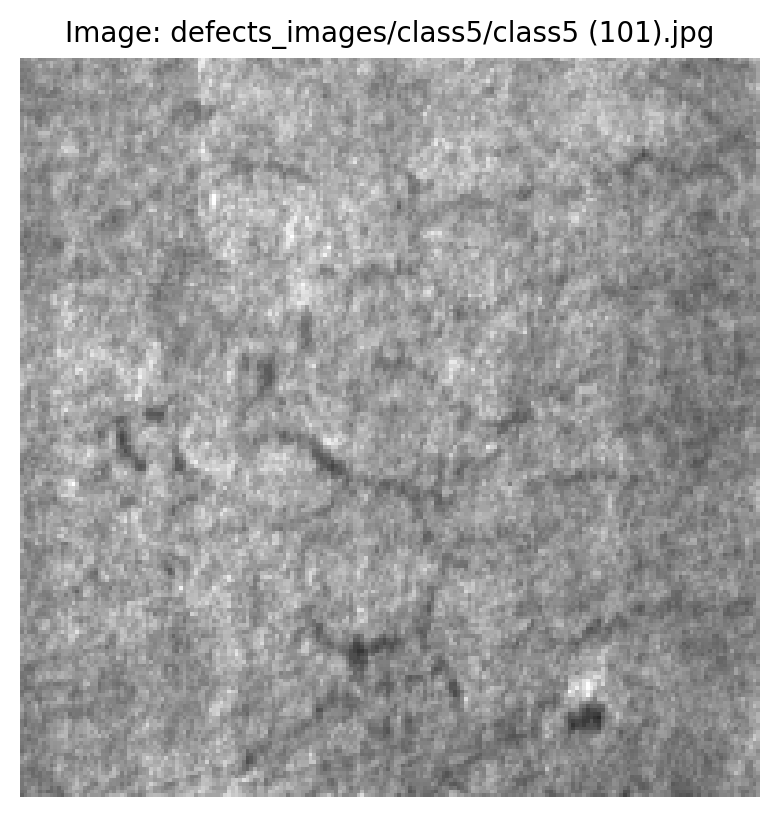

Expected answer:   crazing
GPT-4o baseline:   unknown    (Prediction is INCORRECT)
GPT-4o Finetuning: crazing    (Prediction is CORRECT)


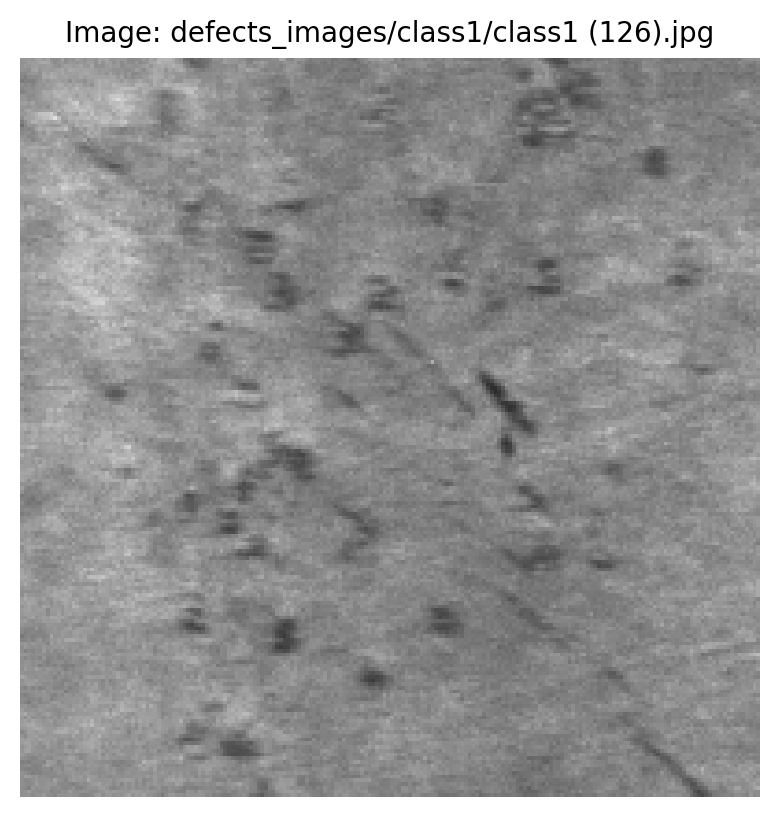

Expected answer:   rolled_in_scale
GPT-4o baseline:   pitted_surface (Prediction is INCORRECT)
GPT-4o Finetuning: pitted_surface (Prediction is INCORRECT)


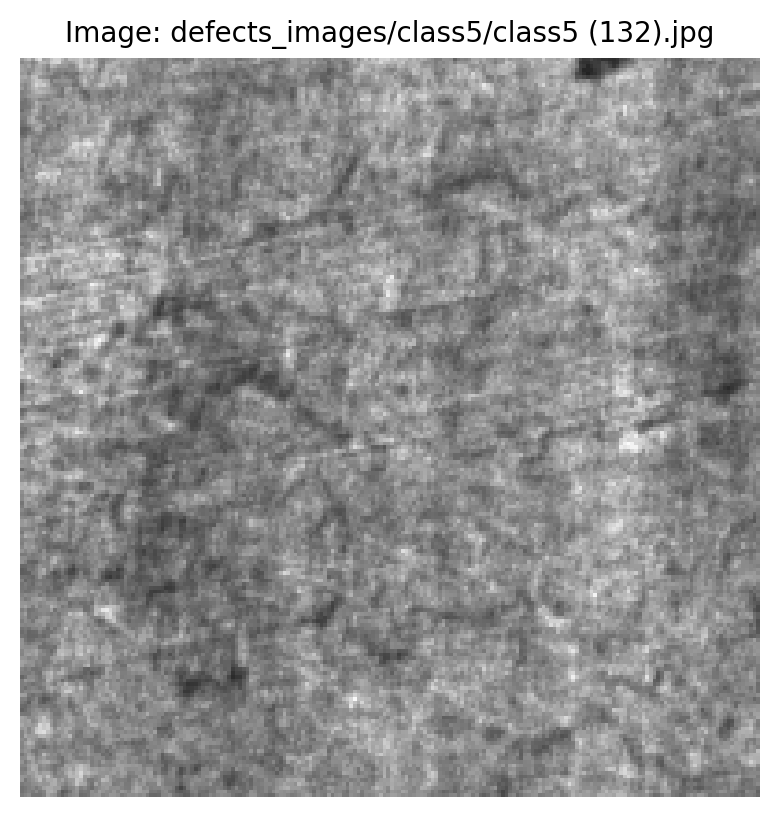

Expected answer:   crazing
GPT-4o baseline:   scratches  (Prediction is INCORRECT)
GPT-4o Finetuning: crazing    (Prediction is CORRECT)


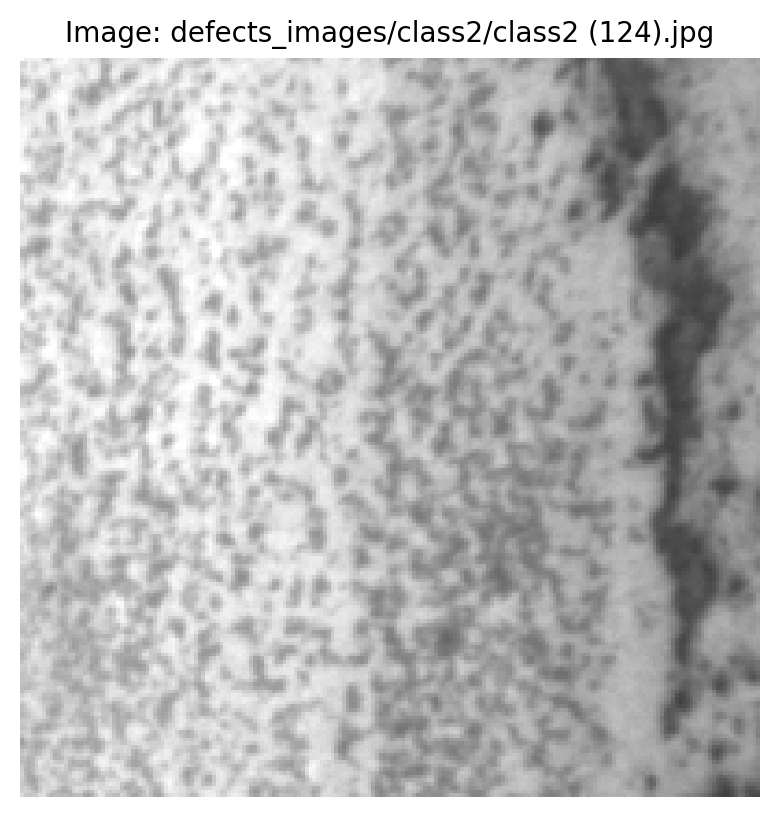

Expected answer:   pitted_surface
GPT-4o baseline:   patches    (Prediction is INCORRECT)
GPT-4o Finetuning: pitted_surface (Prediction is CORRECT)


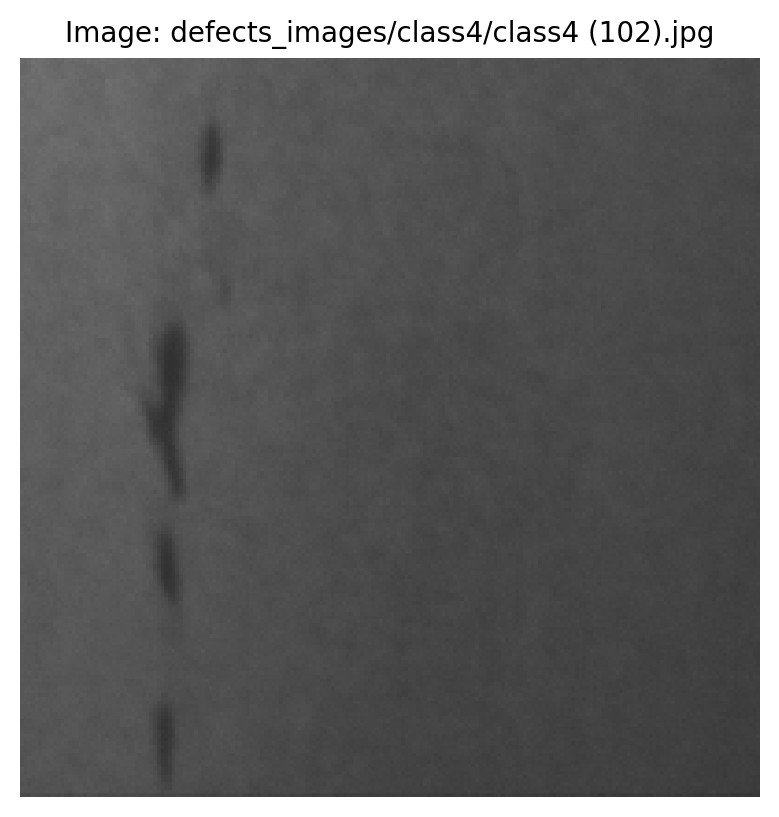

Expected answer:   inclusion
GPT-4o baseline:   scratches  (Prediction is INCORRECT)
GPT-4o Finetuning: inclusion  (Prediction is CORRECT)


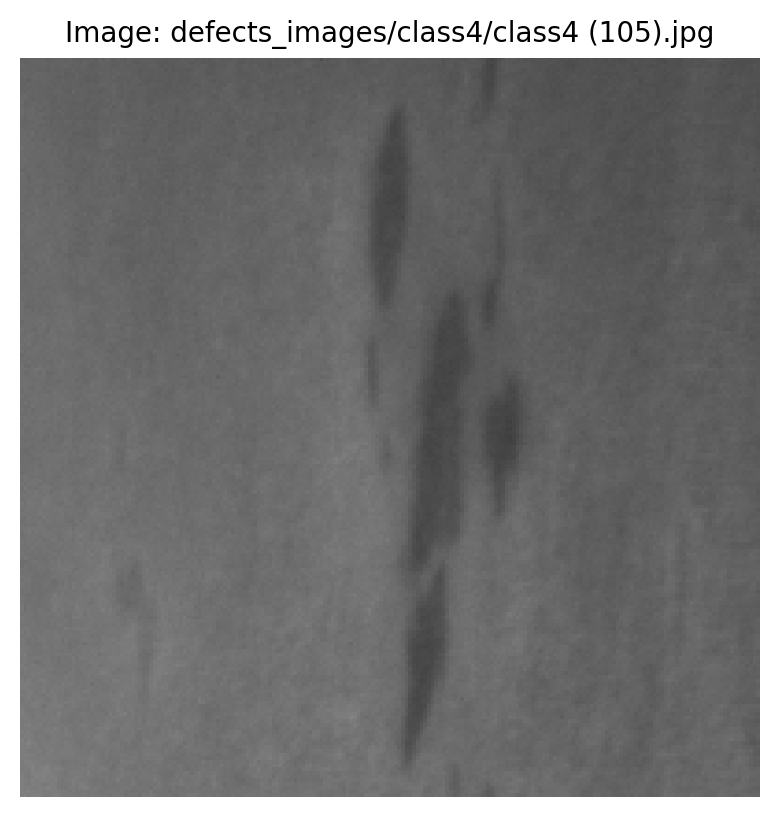

Expected answer:   inclusion
GPT-4o baseline:   scratches  (Prediction is INCORRECT)
GPT-4o Finetuning: inclusion  (Prediction is CORRECT)


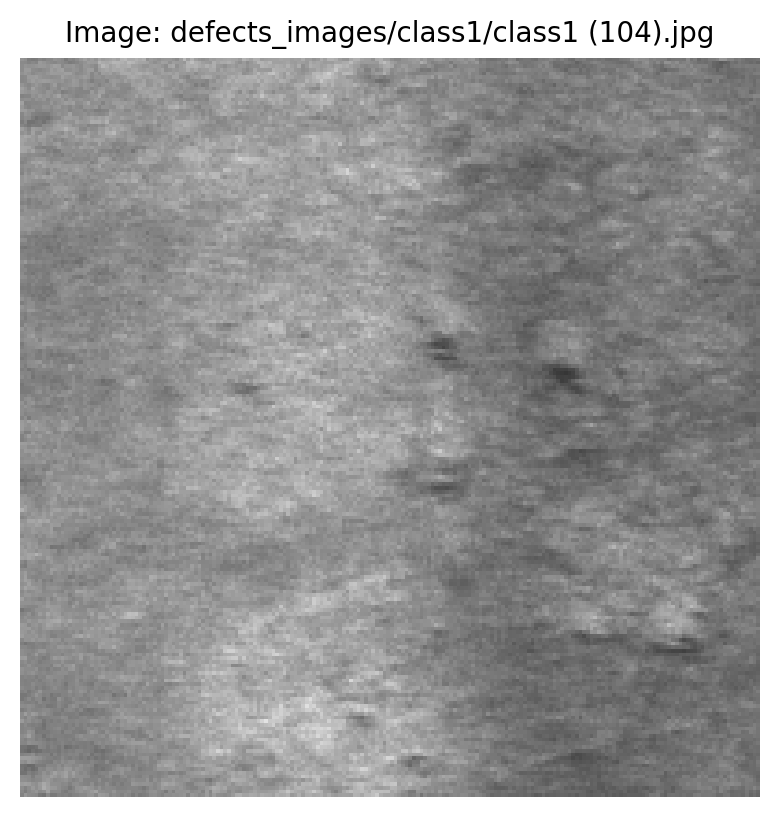

Expected answer:   rolled_in_scale
GPT-4o baseline:   unknown    (Prediction is INCORRECT)
GPT-4o Finetuning: rolled_in_scale (Prediction is CORRECT)


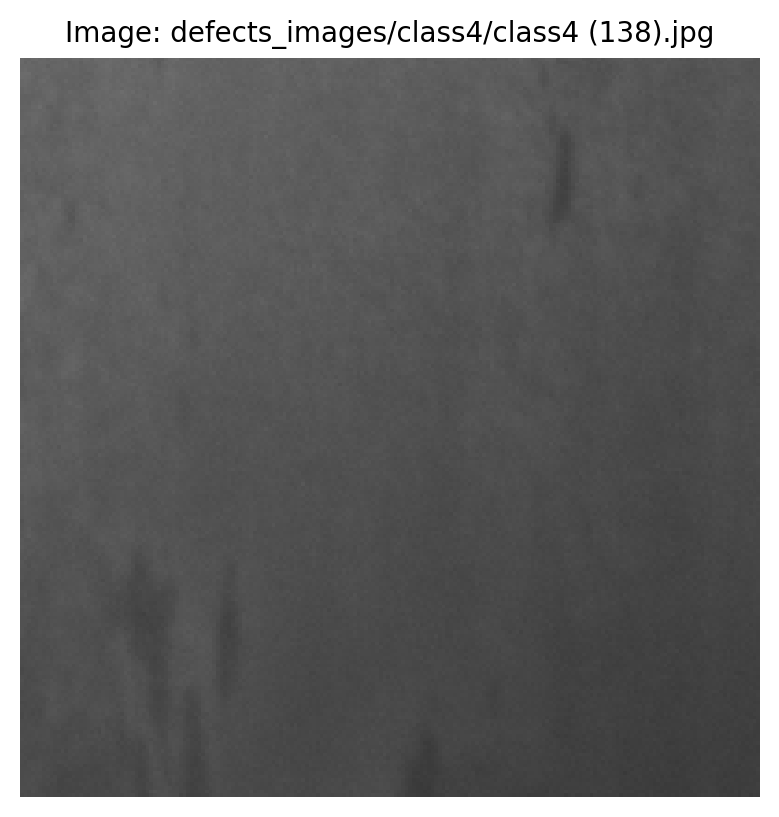

Expected answer:   inclusion
GPT-4o baseline:   scratches  (Prediction is INCORRECT)
GPT-4o Finetuning: inclusion  (Prediction is CORRECT)


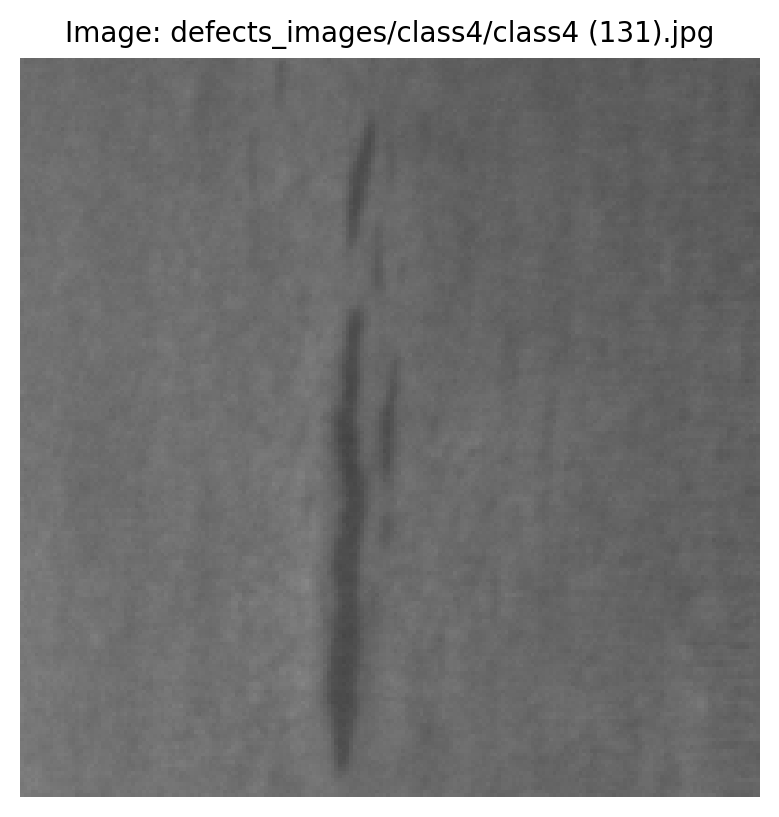

Expected answer:   inclusion
GPT-4o baseline:   scratches  (Prediction is INCORRECT)
GPT-4o Finetuning: scratches  (Prediction is INCORRECT)


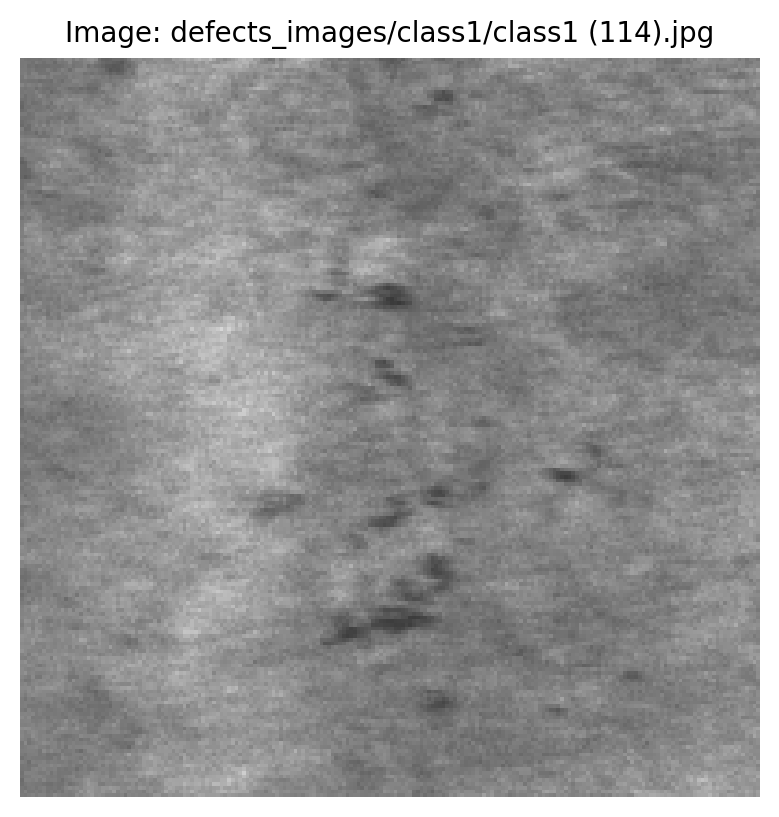

Expected answer:   rolled_in_scale
GPT-4o baseline:   patches    (Prediction is INCORRECT)
GPT-4o Finetuning: rolled_in_scale (Prediction is CORRECT)


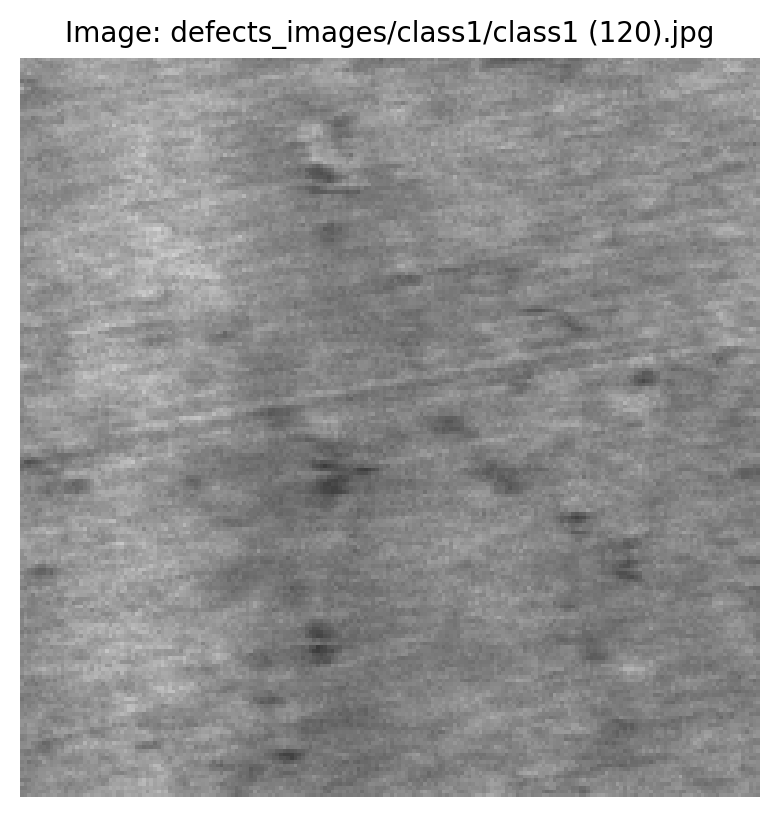

Expected answer:   rolled_in_scale
GPT-4o baseline:   pitted_surface (Prediction is INCORRECT)
GPT-4o Finetuning: rolled_in_scale (Prediction is CORRECT)


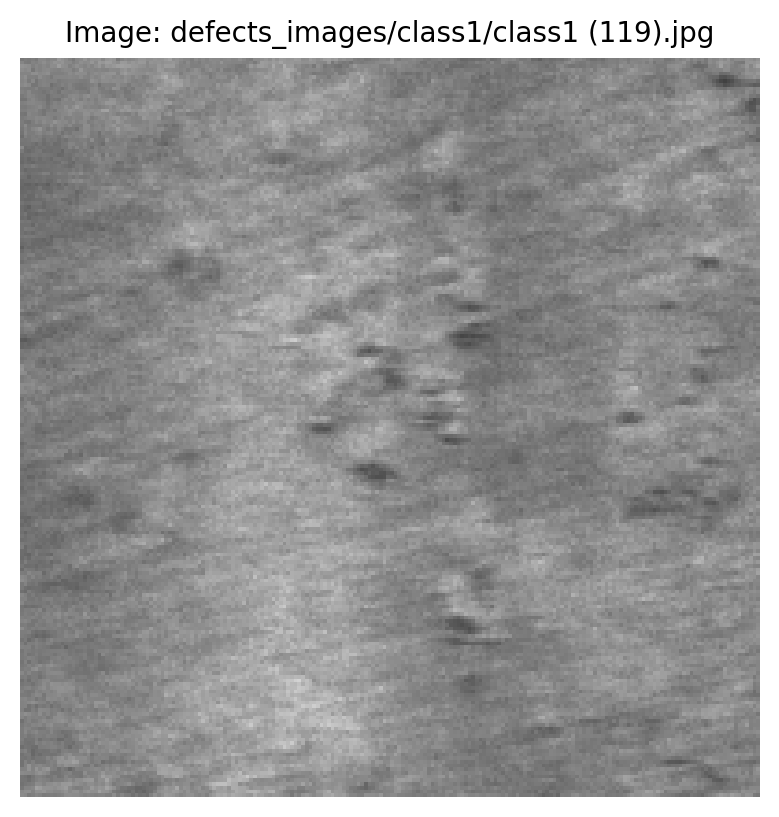

Expected answer:   rolled_in_scale
GPT-4o baseline:   pitted_surface (Prediction is INCORRECT)
GPT-4o Finetuning: rolled_in_scale (Prediction is CORRECT)


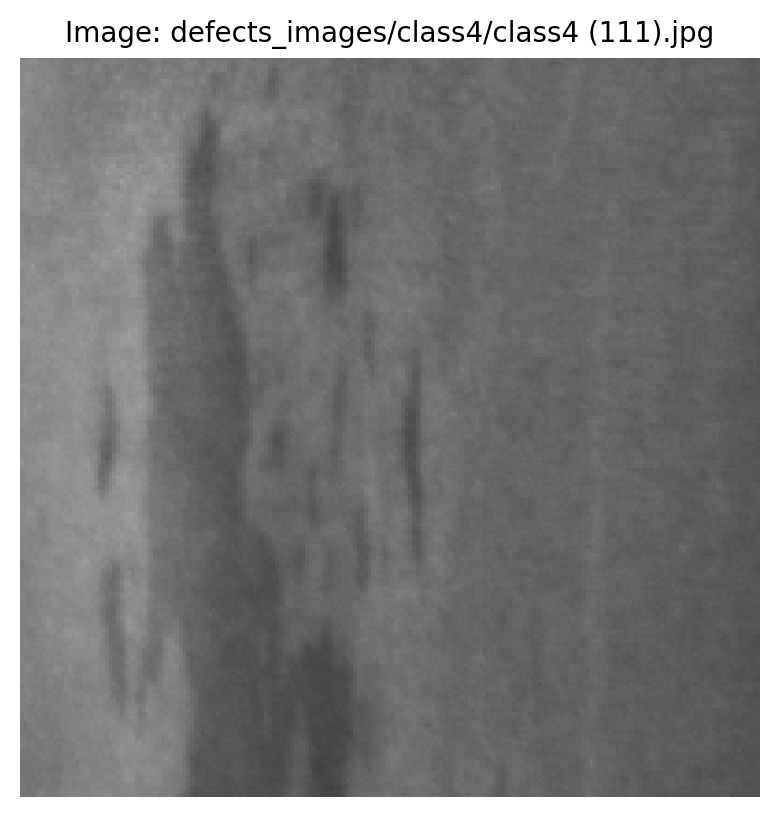

Expected answer:   inclusion
GPT-4o baseline:   scratches  (Prediction is INCORRECT)
GPT-4o Finetuning: inclusion  (Prediction is CORRECT)


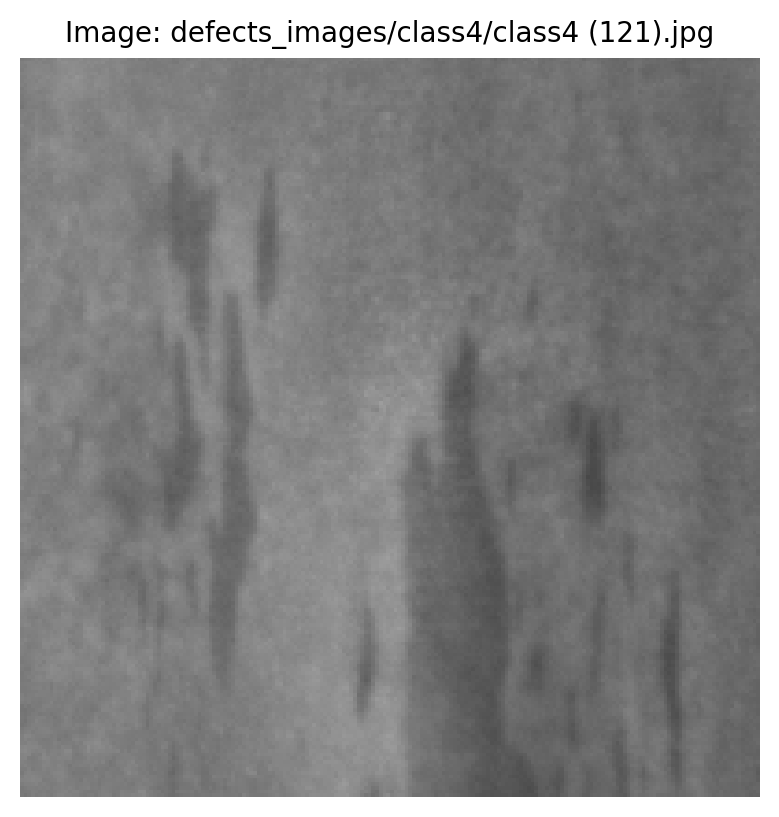

Expected answer:   inclusion
GPT-4o baseline:   patches    (Prediction is INCORRECT)
GPT-4o Finetuning: inclusion  (Prediction is CORRECT)


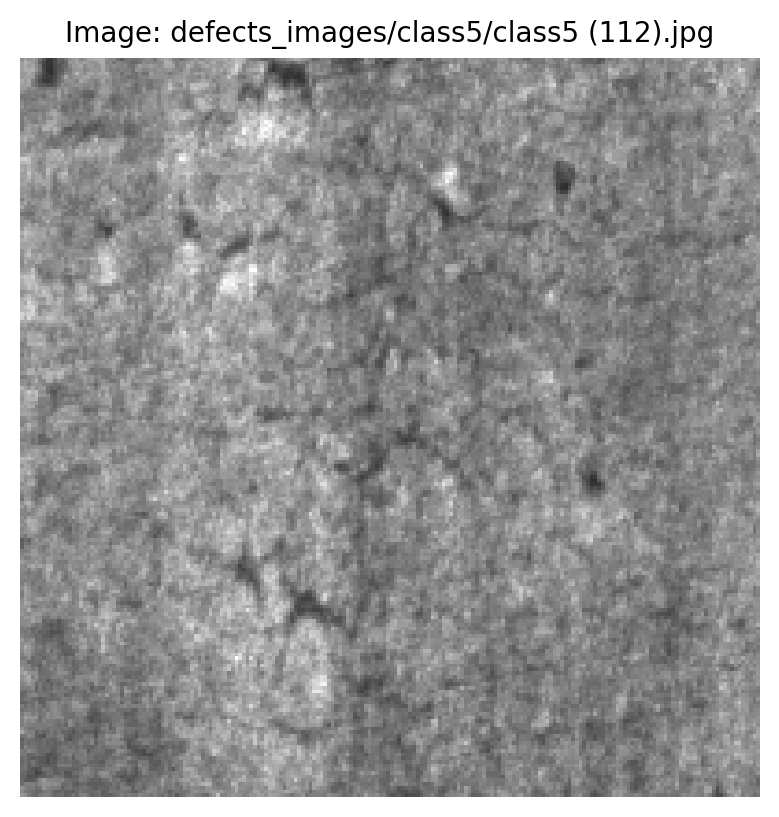

Expected answer:   crazing
GPT-4o baseline:   pitted_surface (Prediction is INCORRECT)
GPT-4o Finetuning: crazing    (Prediction is CORRECT)


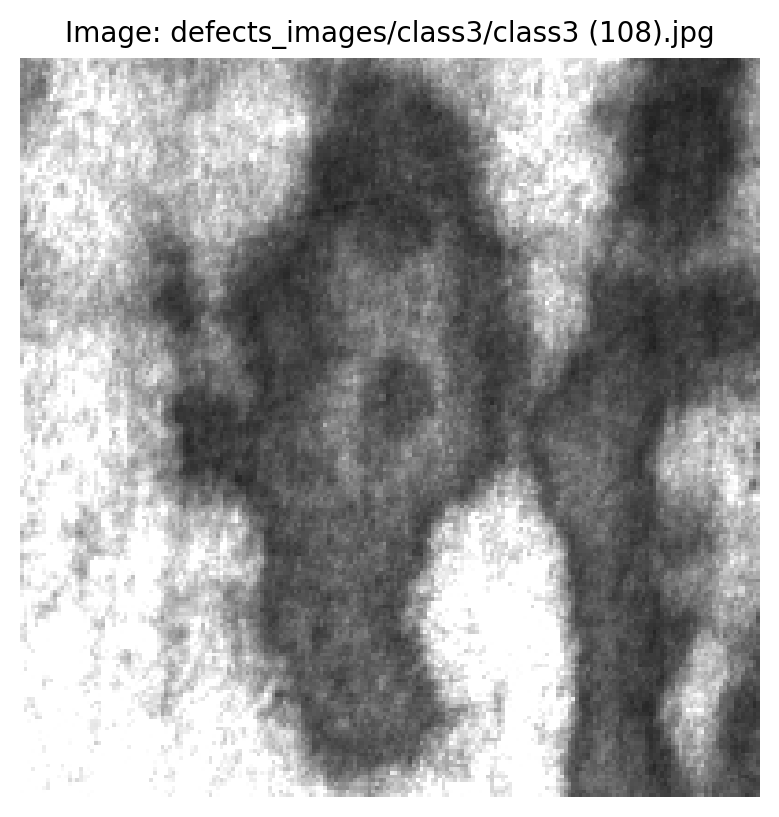

Expected answer:   patches
GPT-4o baseline:   crazing    (Prediction is INCORRECT)
GPT-4o Finetuning: patches    (Prediction is CORRECT)


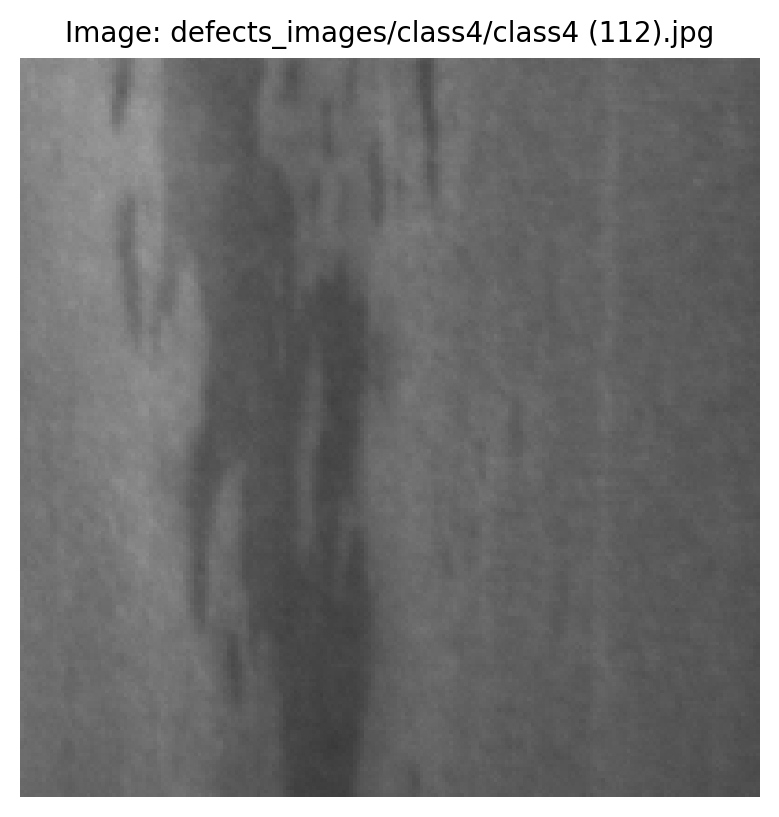

Expected answer:   inclusion
GPT-4o baseline:   crazing    (Prediction is INCORRECT)
GPT-4o Finetuning: inclusion  (Prediction is CORRECT)


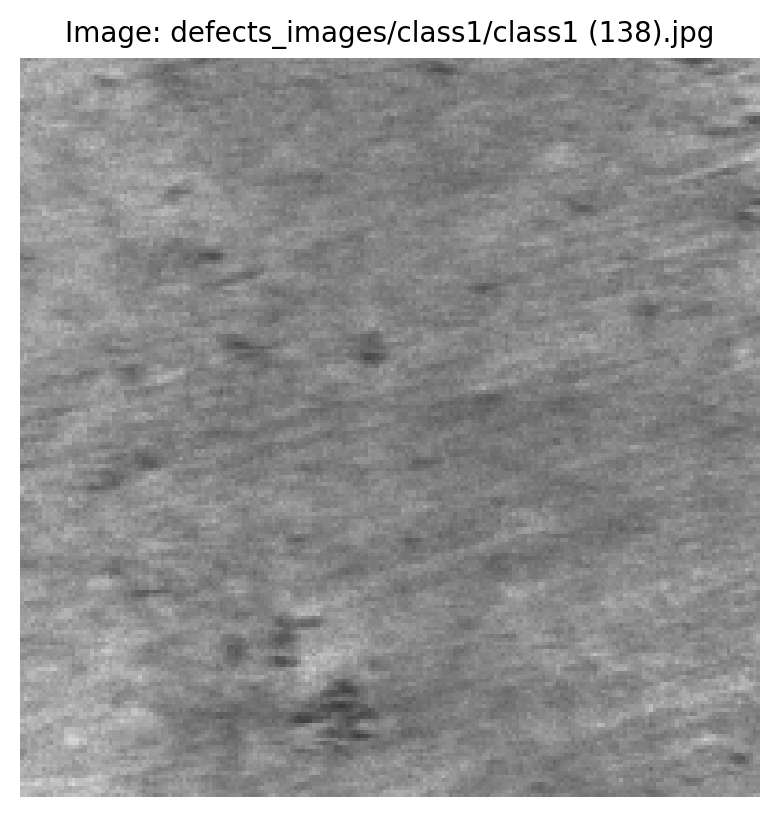

Expected answer:   rolled_in_scale
GPT-4o baseline:   unknown    (Prediction is INCORRECT)
GPT-4o Finetuning: rolled_in_scale (Prediction is CORRECT)


In [137]:
for index, row in ds_test.iterrows():
    base_res = "CORRECT" if row['gpt-4o-base-pred'] == row["answer"] else "INCORRECT"
    
    if base_res == "INCORRECT":
        img = Image.open(row['image_file'])
        plt.imshow(img)
        plt.title(f"Image: {row['image_file']}", size=10)
        plt.axis('off')
        plt.show()
        
        ft_res = "CORRECT" if row['gpt-4o-ft-pred'] == row["answer"] else "INCORRECT"
        print(f"Expected answer:   {row['answer']}")
        print(f"GPT-4o baseline:   {row['gpt-4o-base-pred']:10} (Prediction is {base_res})")
        print(f"GPT-4o Finetuning: {row['gpt-4o-ft-pred']:10} (Prediction is {ft_res})")